# Dissertation code base (Version 1.1)

## Title: Natural Language Processing and Security - Pre-processing, Training and Modelling

### Created by: Samuel William Mason
### Student no: 210418060

# Import libraries

In [1]:
# Primary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import torchtext
import os, sys
import re
import string
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import seaborn as sns

# Secodnary libraries
from kneed import KneeLocator
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')
from wordcloud import WordCloud
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from textblob import TextBlob
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Neural network
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Constant values

In [2]:
# Reproducibility
np.random.seed(1234)
neg_noofrows = 6000  # number of rows to read from negative dataset
nomral_noofrows = 14000 # number of rows to read from combined dataset
maximum_tweet_length = 300 # Max tweet text size
maximum_word_count = 20000 # Max tweet word count
embed_dim = 300
training_size_split = 0.6
test_size_split = 0.4
rate_of_learning = 0.1
epochs= 10

# TEST FILENAME
test1 = "non_phishing_tweets_university.csv"
test2 = "non_phishing_tweets_individual.csv"
# TRAIN FILENAME
train1 = "phishing_tweets_domain.csv"
train2 = "phishing_tweets_url.csv"

# Reading, merging and cleaning our datasets

In [3]:
# Read test data
testData1 = pd.read_csv(test1)
testData2 = pd.read_csv(test2)
# Read train data
trainData1 = pd.read_csv(train1)
trainData2 = pd.read_csv(train2)


### NOTE: Due to RAM constarints a small sample was taken to reduce the overall amount of data required for analysis and therefore processing strain

In [4]:
# Sample distribution
testData1 = testData1.sample(frac=0.1)
testData2 = testData2.sample(frac=0.1)
trainData1 = trainData1.sample(frac=0.1)
trainData2 = trainData2.sample(frac=0.1)

# Combine and merging tweets into one main dataset
dataCombined = [testData1, testData2, trainData1, trainData2]
dfCombined = pd.concat(dataCombined)
                       
# Ham Dataset                       
ham_df = dfCombined[dfCombined.Status == 0]
# Spam Dataset
spam_df = dfCombined[dfCombined.Status == 1]

### NOTE: Duplicate values were removed from the dataset to esnure that no conspicous values interputed further modelling

In [5]:
## Checking for duplicates in dataframe
print("\nChecking for duplicate values")
print("-------------------------------")
print("Total no of duplicate tweets: ") # Check for duplicate values
print(str(dfCombined.duplicated(subset='Tweet Id').sum()))
print("\n")

if dfCombined.duplicated(subset='Tweet Id').sum() >= 1:
    dfCombined = dfCombined.drop_duplicates(subset=['Tweet Id']) # drop duplicate values
    print("Duplicate values have successfully been dropped")
else:
    print("No duplicate values have been dropped")


Checking for duplicate values
-------------------------------
Total no of duplicate tweets: 
81


Duplicate values have successfully been dropped


### NOTE: 'NaN' values were altered from the dataset to ensure a 0 value was given instead of 'NaN'

In [6]:
## Checking for 'NaN'values in dataframe

count_nan = dfCombined.isna().sum().sum()

print("\nChecking for null values")
print("-------------------------------")
print("Total number of null values: ")# Check for duplicate values
print(count_nan)# Check for duplicate values
print("\n")

if int(count_nan) >= 1:
    dfCombined = dfCombined.fillna(0) # Alter NaN values
    print("NaN values have successfully been altered")
else:
    print("No null values have been altered")


Checking for null values
-------------------------------
Total number of null values: 
5040


NaN values have successfully been altered


# Visualising our datasets


Total distribution of our inital educational and known-phishing datasets
---------------------------------------------------------
Test data 1
0    2201
Name: Status, dtype: int64
Test data 2
0    1075
Name: Status, dtype: int64
Train data 1
1    923
Name: Status, dtype: int64
Train data 2
1    923
Name: Status, dtype: int64
---------------------------------------------------------


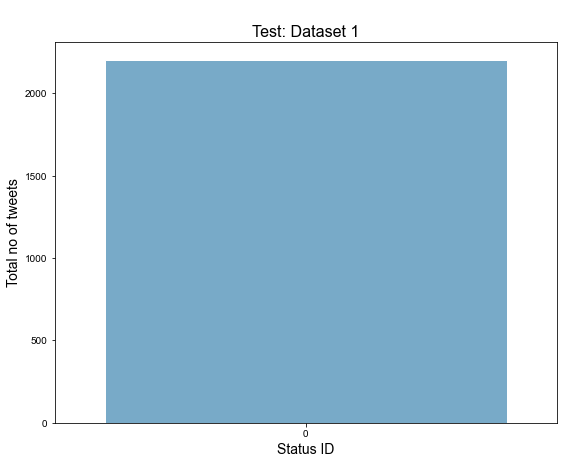

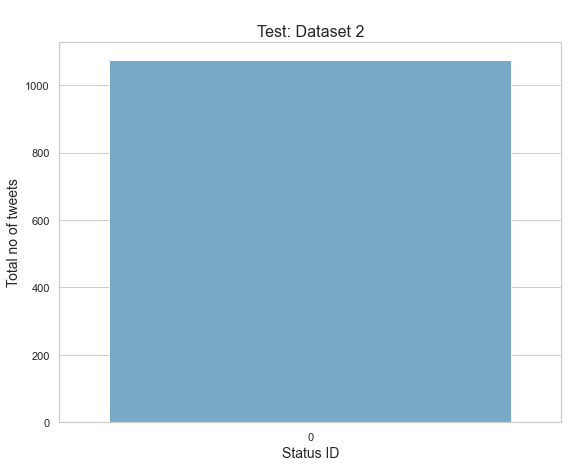

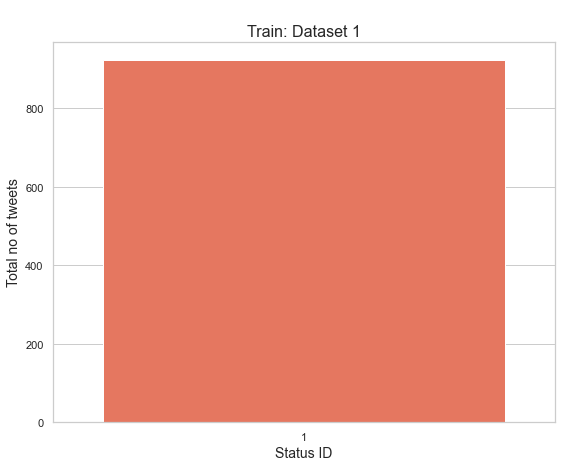

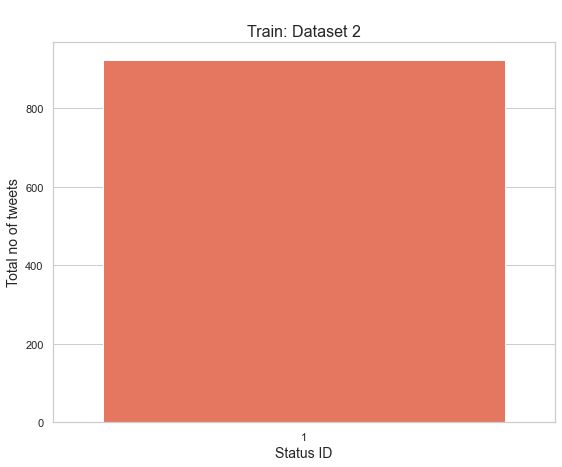

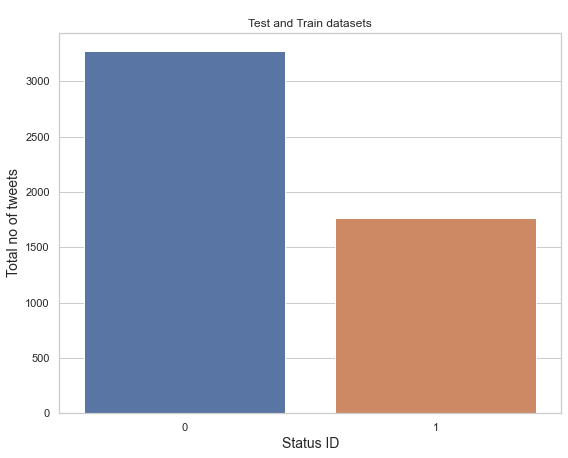

In [7]:
# Visualise dataset count difference
print("\nTotal distribution of our inital educational and known-phishing datasets")
print("---------------------------------------------------------")
print("Test data 1")
print (testData1.Status.value_counts())
print("Test data 2")
print (testData2.Status.value_counts())
print("Train data 1")
print (trainData1.Status.value_counts())
print("Train data 2")
print (trainData2.Status.value_counts())
print("---------------------------------------------------------")

# visualise test1 dataset spread
PG = plt.figure(figsize=(9,7))
plt.title("\nTest: Dataset 1", fontsize=16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=testData1.Status.unique(), y=testData1.Status.value_counts(), palette = 'Blues')
ax.set(xlabel='Status ID');
ax.set(ylabel = 'Total no of tweets')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

# visualise test2 dataset spread
PG = plt.figure(figsize=(9,7))
plt.title("\nTest: Dataset 2", fontsize=16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=testData2.Status.unique(), y=testData2.Status.value_counts(), palette = 'Blues')
ax.set(xlabel='Status ID');
ax.set(ylabel = 'Total no of tweets')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

# visualise train1 dataset spread
PG = plt.figure(figsize=(9,7))
plt.title("\nTrain: Dataset 1", fontsize=16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=trainData1.Status.unique(), y=trainData1.Status.value_counts(), palette = 'Reds')
ax.set(xlabel='Status ID');
ax.set(ylabel = 'Total no of tweets')
# setting label sizes after creation
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

# visualise train2 dataset spread
PG = plt.figure(figsize=(9,7))
plt.title("\nTrain: Dataset 2", fontsize=16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=trainData2.Status.unique(), y=trainData2.Status.value_counts(), palette = 'Reds')
ax.set(xlabel='Status ID');
ax.set(ylabel = 'Total no of tweets')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

# visualise final dataset spread
PG = plt.figure(figsize=(9,7))
plt.title("\nTest and Train datasets")
ax = sns.barplot(x=dfCombined.Status.unique(), y=dfCombined.Status.value_counts())
ax.set(xlabel='Status ID');
ax.set(ylabel = 'Total no of tweets')
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
plt.show()

# Exploring our datasets and their attributes

In [8]:
# Exploring any information
dfCombined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5041 entries, 21607 to 3872
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5041 non-null   int64 
 1   Datetime    5041 non-null   object
 2   Tweet Id    5041 non-null   int64 
 3   Username    5041 non-null   object
 4   Text        5041 non-null   object
 5   Retweet     5041 non-null   int64 
 6   Like        5041 non-null   int64 
 7   Quote       5041 non-null   int64 
 8   Reply       5041 non-null   int64 
 9   Media       5041 non-null   object
 10  Language    5041 non-null   object
 11  Outlinks    5041 non-null   object
 12  Source      5041 non-null   object
 13  Status      5041 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 590.7+ KB


In [9]:
# Exploring any values
dfCombined.isnull().sum()

Unnamed: 0    0
Datetime      0
Tweet Id      0
Username      0
Text          0
Retweet       0
Like          0
Quote         0
Reply         0
Media         0
Language      0
Outlinks      0
Source        0
Status        0
dtype: int64

# Identifying any unique tweet identifiers and adding associated columns

### NOTE: Due to some datatypes, I decided to introduce tools that converts type object to other types 

In [10]:
def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')

def listToStringWithoutCharacters(list1):
    return str(list1).replace('[','').replace(']','').replace('_',' '). replace(',',' '). replace('.',' ')

def listToListWithoutCharacters(list1):
    return (list1).replace('[','').replace(']','').replace('_', ' '). replace(',',' '). replace('.',' ')

### Hashtag features

In [11]:
has_hashtags = []
num_hashtags = []


for i in range(0,len(dfCombined)):
    if '#' in dfCombined.Text.iloc[i]:
        has_hashtags.append(1)
        num_hashtags.append(dfCombined.Text.iloc[i].count('#'))
    else:
        has_hashtags.append(0)
        num_hashtags.append(0)

    
dfCombined['has_hashtags'] = has_hashtags
dfCombined['num_hashtags'] = num_hashtags

### URL features

In [12]:
has_urls = []
num_urls = []

for i in range(0,len(dfCombined)):
    if 'https:' in listToStringWithoutBrackets(dfCombined.Outlinks.iloc[i]):
        has_urls.append(1)
        num_urls.append(dfCombined.Outlinks.iloc[i].count('https:'))
    else:
        has_urls.append(0)
        num_urls.append(0)

dfCombined['has_urls'] = has_urls
dfCombined['num_urls'] = num_urls

### Quote features

In [13]:
has_quote_count = []

for i in range(0,len(dfCombined)):
    if(dfCombined.Quote.iloc[i] == 0):
        has_quote_count.append(0)
    else:
        has_quote_count.append(1)

dfCombined['has_quote_count'] = has_quote_count

### Like features 

In [14]:
has_like_count = []

for i in range(0,len(dfCombined)):
    if(dfCombined.Like.iloc[i] == 0):
        has_like_count.append(0)
    else:
        has_like_count.append(1)

dfCombined['has_like_count'] = has_like_count

### Retweet features

In [15]:
has_retweet_count = []

for i in range(0,len(dfCombined)):
    if(dfCombined.Retweet.iloc[i] == 0):
        has_retweet_count.append(0)
    else:
        has_retweet_count.append(1)
    
dfCombined['has_retweet_count'] = has_retweet_count

### Tweet length

In [16]:
text_length = []

for i in range(0,len(dfCombined)):
    text_length.append(len(dfCombined.Text.iloc[i]))
 
dfCombined['Tweet_length'] = text_length

### Tweet digits

In [17]:
digits_list = []

for i in range(0,len(dfCombined)):
    if(sum(c.isdigit() for c in dfCombined.Text.iloc[i]) == 0):
        digits_list.append(0)
    else:
        digits_list.append(sum(c.isdigit() for c in dfCombined.Text.iloc[i]))

digits_col = pd.Series(digits_list)
dfCombined['Digit_count'] = digits_col.values

### Capitals words

In [18]:
cap_list = []

for i in range(0,len(dfCombined)):
    words = dfCombined.Text.iloc[i].split()
    count = 0
    for j in range(0,len(words)):
        if(words[j].isupper()):
            count = count + 1;
    cap_list.append(count)    
    #print(cap_list)
        
cap_col = pd.Series(cap_list)
dfCombined['Capital_count'] = cap_col.values

### F-ratio

In [19]:
dfCombined['f_ratio'] = (dfCombined['Tweet_length']+1)/(dfCombined['Tweet_length']+1 + dfCombined['has_urls']+1)

# Word cloud analysis (Prior to text filtering)


Test data related text and URL language
---------------------------------------------------------------


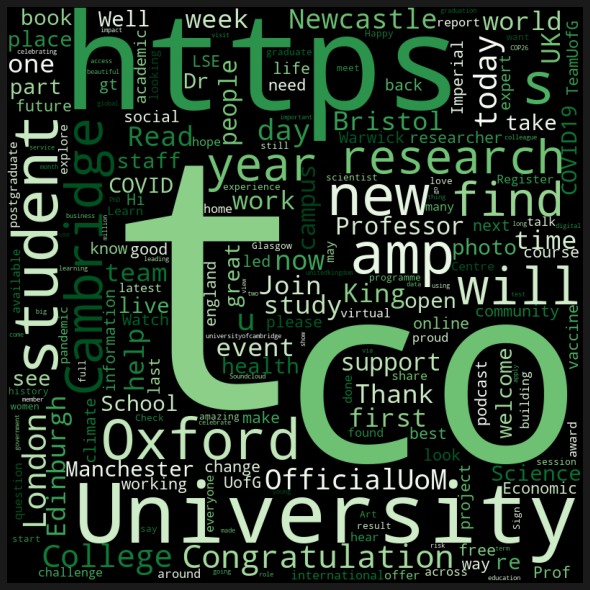


Train data related text and URL language
--------------------------------------------------------------


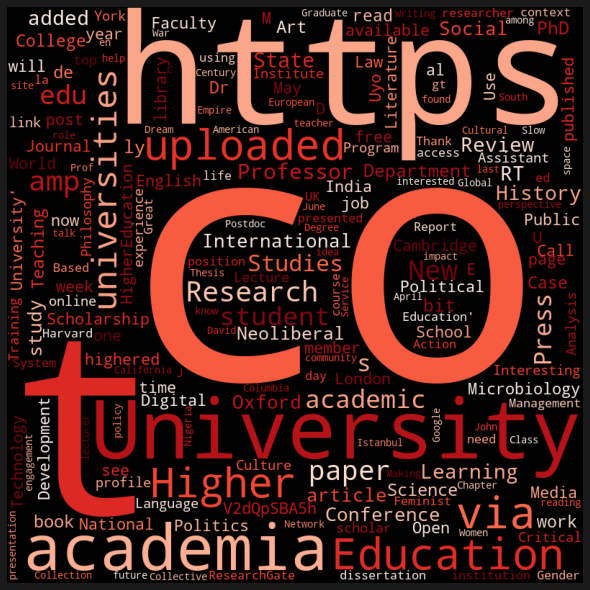

In [20]:
# Test data analysis
print("\nTest data related text and URL language")
print("---------------------------------------------------------------")
test_words = ' '.join(list(ham_df[ham_df['Status'] == 0]['Text']))
test_wc = WordCloud(width = 800, height = 800, collocations=False, colormap="Greens").generate(test_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(test_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Train data analysis
print("\nTrain data related text and URL language")
print("--------------------------------------------------------------")
train_words = ' '.join(list(spam_df[spam_df['Status'] == 1]['Text']))
train_wc = WordCloud(width = 800, height = 800, collocations=False, colormap="Reds").generate(train_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(train_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Filtering text and removing stop words

## Filtering process 1 (Filter text without removing associated charcter types)

In [ ]:
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language

# Filtered text list
filtered_text = []

# Loop through dataset 'Text' column and filter to singular words
for i in range(0,len(dfCombined)):
    word_list = str(dfCombined.Text.iloc[i]).split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_text.append(' '.join(filtered_words))
    
# Add new columns to original dataset (Normal and Lower case)
dfCombined['filtered_text'] = filtered_text
dfCombined['filtered_text_lower'] = dfCombined['filtered_text'].str.lower()

## Filtering process 2 (Filter all text)

In [21]:
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language

# Function to remove stop words and associated character types
def preprocessTweets(tweet):
    tweet = tweet.lower() # Converts text to lower case
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)  # convert string to tokens
    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w in word_list]

    # Remove punctuations
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)  # join words with a space in between them

# function to obtain adjectives from tweets
def getAdjectives(tweet):
    tweet = word_tokenize(tweet)  # convert string to tokens
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(tweet)  # join words with a space in between them

# Defining the NLTK stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + alphabets
word_list = words.words()  # all words in English language

In [22]:
# Apply preProcessTweets function to the 'Text' column to generate a new column called 'Processed Tweets'.
dfCombined['Processed_Tweets'] = dfCombined['Text'].apply(preprocessTweets)

## Filtering process 3 (Filter URL)

In [23]:
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language

# Function to remove stop words and associated character types
def preprocessURL(URL):
    URL = URL.lower() # Converts text to lower case
    # Remove stopwords
    URL_tokens = word_tokenize(URL)  # convert string to tokens
    filtered_words = [w for w in URL_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w in word_list]

    # Remove punctuations
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)  # join words with a space in between them

# Defining the NLTK stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + alphabets
word_list = words.words()  # all words in English language

In [24]:
# Apply preProcessTweets function to the 'Outlinks' column to generate a new column called 'Processed URL'.
dfCombined['Processed_URL'] = dfCombined['Outlinks'].astype(str).apply(preprocessURL)

# Word and URL frequency analysis (Post text filtering)

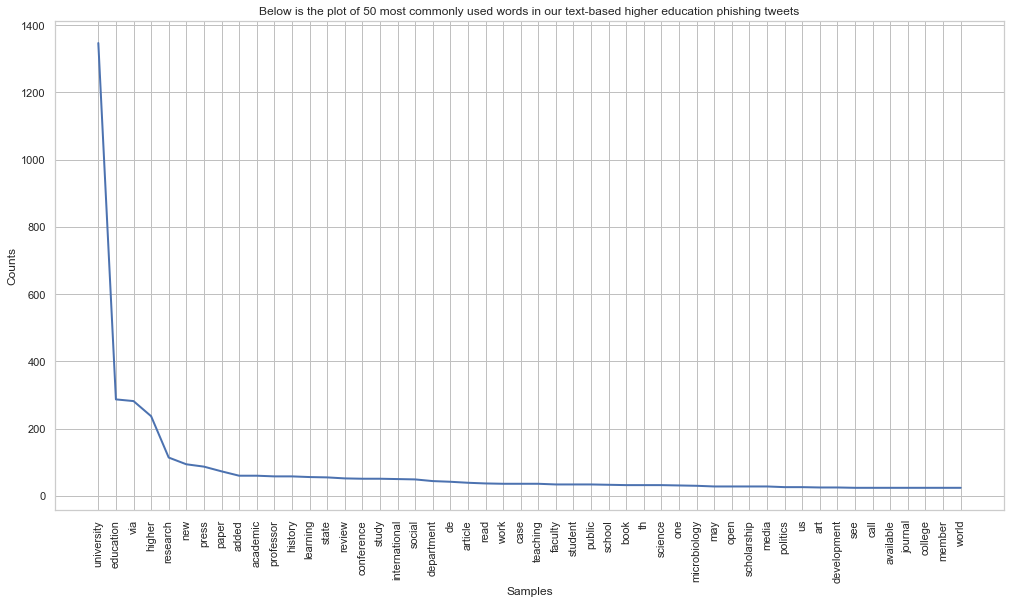

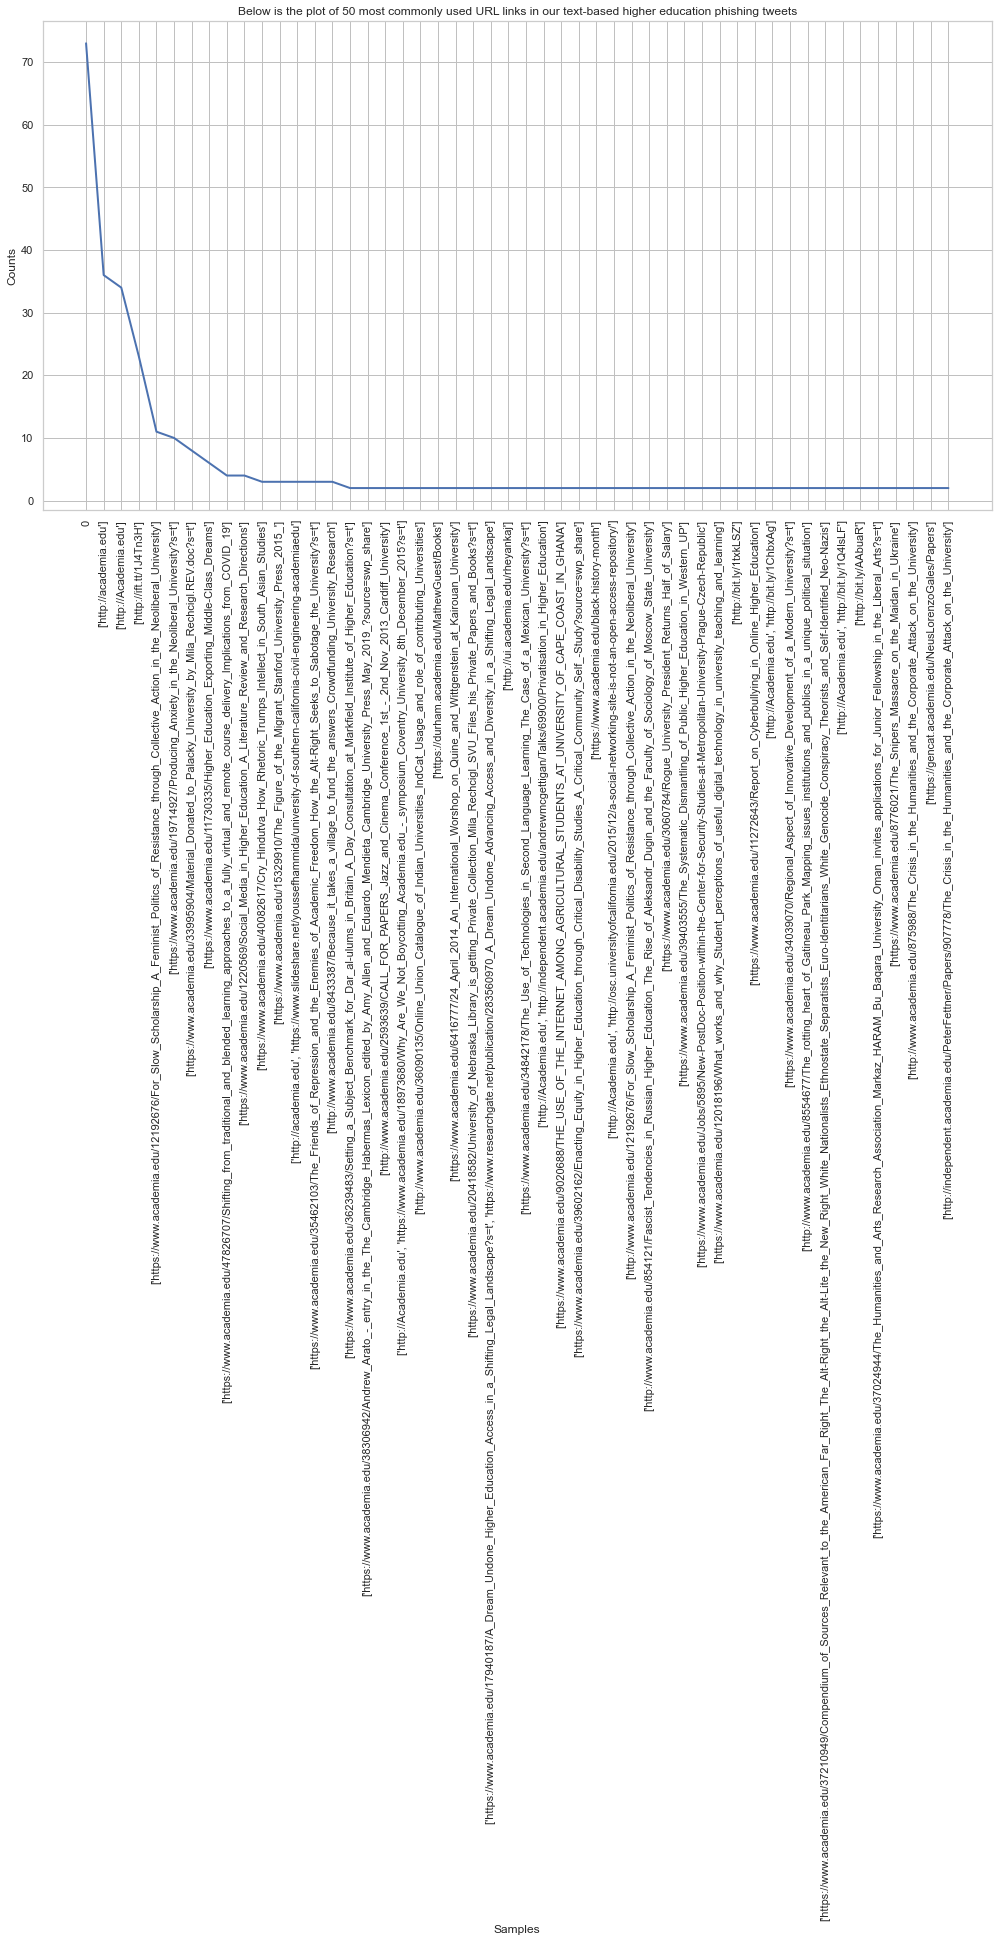

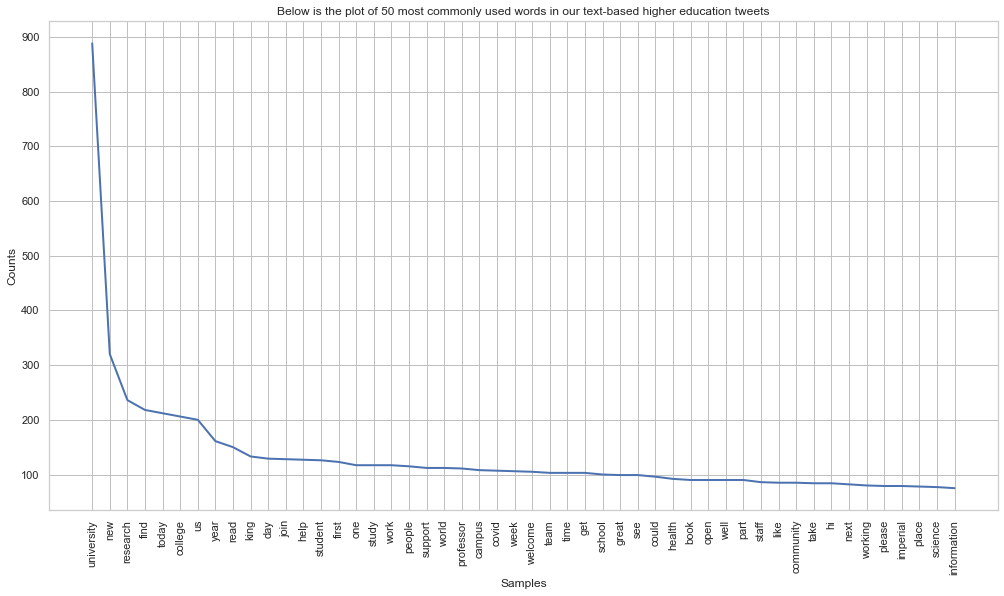

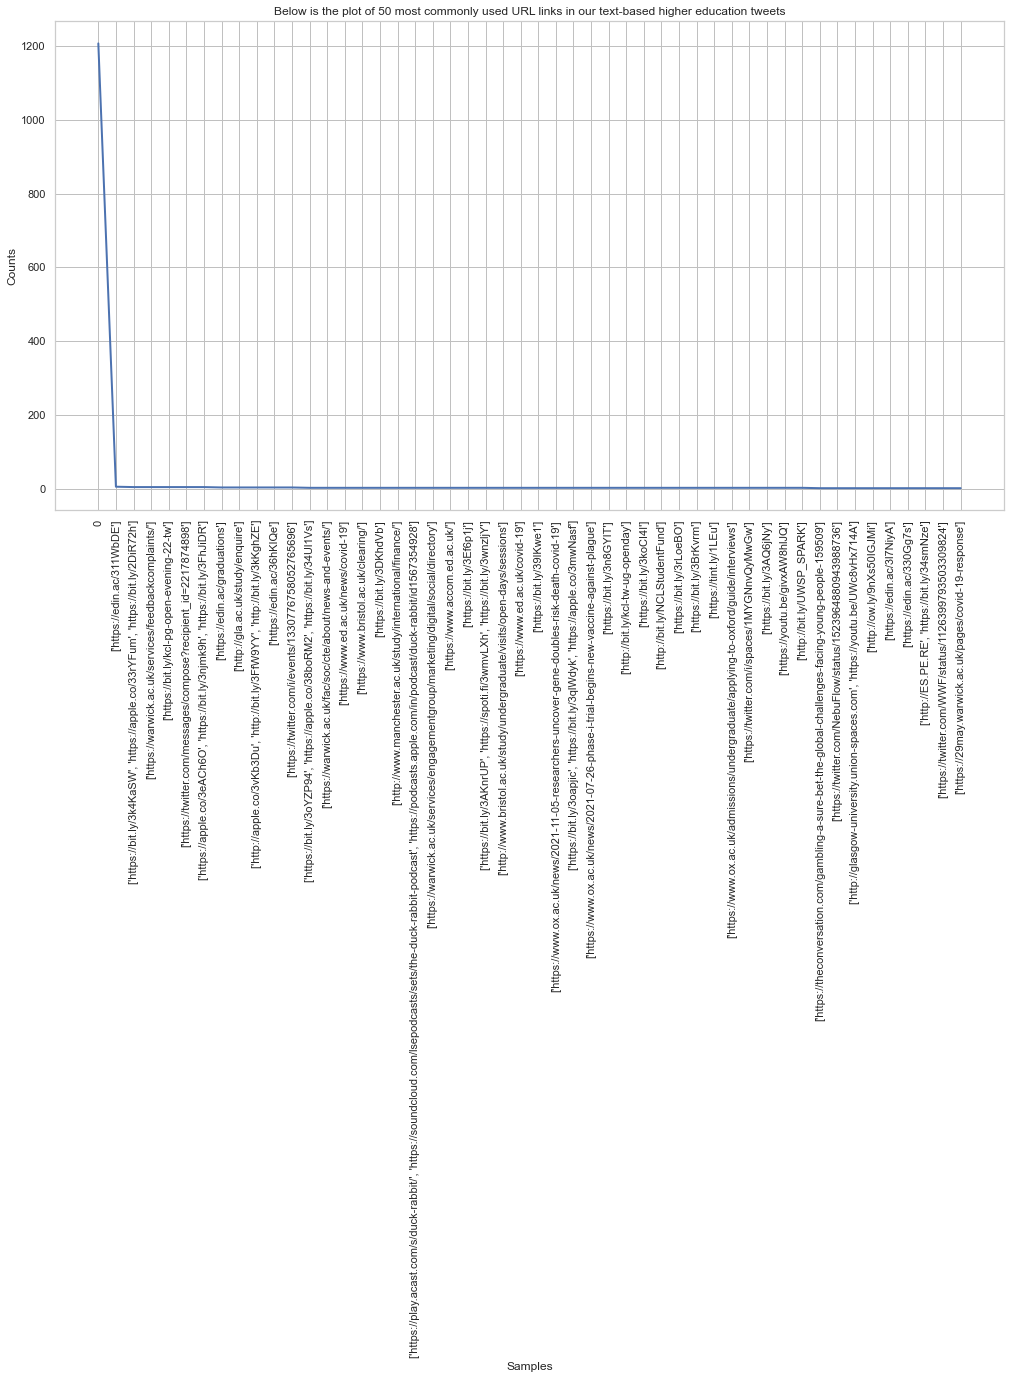

In [25]:
# Lists to contain Phishing related words and URL's
spam_text = []
spam_link = []

spam_df = dfCombined[dfCombined.Status==1]

for i in range(0,len(spam_df)):
    # Append to lists
    spam_text.append(spam_df.Processed_Tweets.iloc[i])
    spam_link.append(spam_df.Outlinks.iloc[i])

# Lists to contain normal related words and URL's
ham_text = []
ham_link = []

ham_df = dfCombined[dfCombined.Status==0]

for i in range(0,len(ham_df)):
    # Append to lists
    ham_text.append(ham_df.Processed_Tweets.iloc[i])
    ham_link.append(ham_df.Outlinks.iloc[i])

# Graphing word and URL frequencies
# Spam text
spam_text = ' '.join(spam_text).split()
spam_text_freq = nltk.FreqDist(spam_text)
spam_link_freq = nltk.FreqDist(spam_link)

# Included for font
plt.rc('axes', unicode_minus=False)

# Phishing graph 1 (Text)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used words in our text-based higher education phishing tweets")
spam_text_freq.most_common(50)
spam_text_freq.plot(50)

# Phishing graph 1 (URL)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used URL links in our text-based higher education phishing tweets")
spam_link_freq.most_common(50)
spam_link_freq.plot(50)

# Normal text
ham_text = ' '.join(ham_text).split()
ham_text_freq = nltk.FreqDist(ham_text)
ham_link_freq = nltk.FreqDist(ham_link)

# Non-phishing graph 1 (Text)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used words in our text-based higher education tweets")
ham_text_freq.most_common(50)
ham_text_freq.plot(50)

# Non-Phishing graph 1 (URL)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used URL links in our text-based higher education tweets")
ham_link_freq.most_common(50)
ham_link_freq.plot(50)        

plt.show()

# Word cloud analysis (Post filtering text)


Spear Phishing data related text and URL language
--------------------------------------------------------------


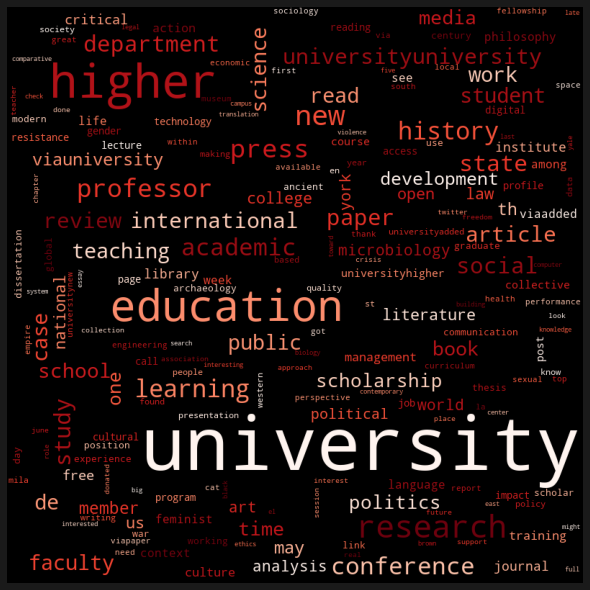


Non-Phishing data related text and URL language
--------------------------------------------------------------


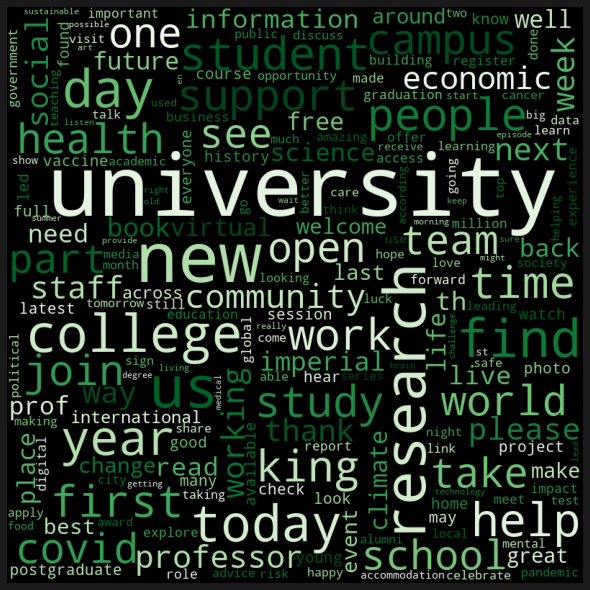

In [26]:
# Phishing text analysis
print("\nSpear Phishing data related text and URL language")
print("--------------------------------------------------------------")
text = ''
for i in range(0,len(spam_df)):
    text = text + str(spam_df.Processed_Tweets.iloc[i])

plt.figure(figsize = (10, 8), facecolor = 'k')
phishing = WordCloud(width = 800, height = 800, collocations=False, colormap="Reds").generate(text)
plt.imshow(phishing)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Non-phishing text analysis
print("\nNon-Phishing data related text and URL language")
print("--------------------------------------------------------------")
text = ''
for i in range(0,len(ham_df)):
    text = text + str(ham_df.Processed_Tweets.iloc[i])

plt.figure(figsize = (10, 8), facecolor = 'k')
non_phishing = WordCloud(width = 800, height = 800, collocations=False, colormap="Greens").generate(text)
plt.imshow(non_phishing)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Sentiment analysis

In [27]:
# function to return words to their base form using Lemmatizer
def preprocessTweetsSentiments(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # instatiate an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

# Create function to obtain Subjectivity Score
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# Create function to obtain Polarity Score
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Create function to obtain Sentiment category
def getSentimentTextBlob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"
    
dfCombined['Tweets_Sentiments'] = dfCombined['Processed_Tweets'].apply(preprocessTweetsSentiments)
    
# Apply all functions above to respective columns
dfCombined['Subjectivity']=dfCombined['Tweets_Sentiments'].apply(getSubjectivity)
dfCombined['Polarity']=dfCombined['Tweets_Sentiments'].apply(getPolarity)
dfCombined['Sentiment']=dfCombined['Polarity'].apply(getSentimentTextBlob)

print("\nThese are the polarity and subjectivity ranges that determine the overall sentiment in text\n")
print("The polarity score is a float within the range [-1.0, 1.0]. \nThe subjectivity is a float within the range [0.0, 1.0] \nwhere 0.0 is very objective and 1.0 is very subjective.")            


These are the polarity and subjectivity ranges that determine the overall sentiment in text

The polarity score is a float within the range [-1.0, 1.0]. 
The subjectivity is a float within the range [0.0, 1.0] 
where 0.0 is very objective and 1.0 is very subjective.


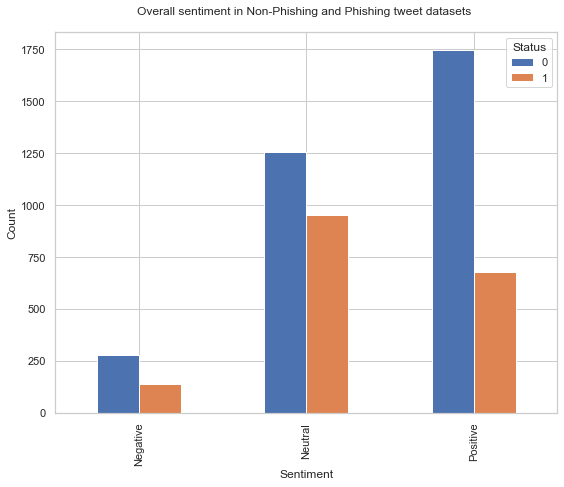

In [28]:
# Display bar chart
plt.rcParams["figure.figsize"] = (9,7)
res= dfCombined.groupby(['Status','Sentiment'])['Processed_Tweets'].count()
res.unstack(level=0).plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Overall sentiment in Non-Phishing and Phishing tweet datasets \n")

# Show graph
plt.show()

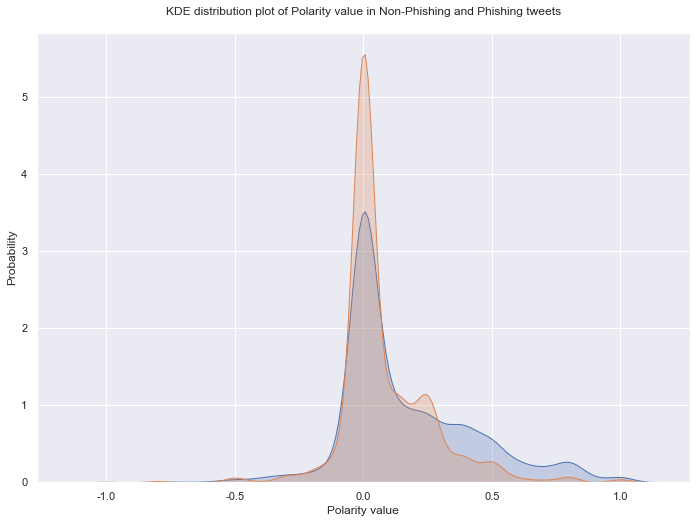

In [29]:
# Display polarity bar chart
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
res=[x for x in list(dfCombined[dfCombined.Status==0].Polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Non-Phishing");
res=[x for x in list(dfCombined[dfCombined.Status==1].Polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Phishing");
plt.title("KDE distribution plot of Polarity value in Non-Phishing and Phishing tweets\n")
plt.xlabel("Polarity value")
plt.ylabel("Probability")
plt.show()

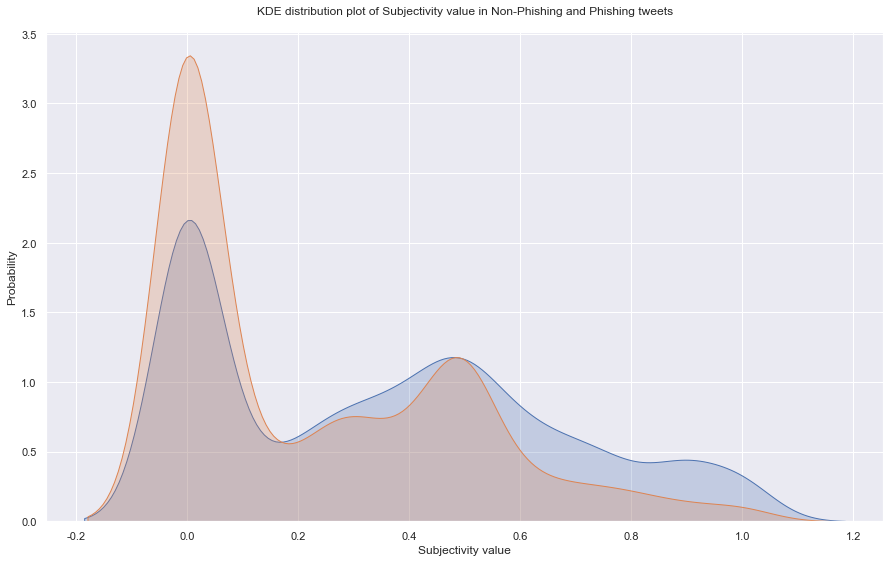

In [30]:
# Dispay subjectivity bar chart
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15,9)})
res=[x for x in list(dfCombined[dfCombined.Status==0].Subjectivity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Non-Phishing");
res=[x for x in list(dfCombined[dfCombined.Status==1].Subjectivity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Phishing");
plt.title("KDE distribution plot of Subjectivity value in Non-Phishing and Phishing tweets\n")
plt.xlabel("Subjectivity value")
plt.ylabel("Probability")
plt.show()

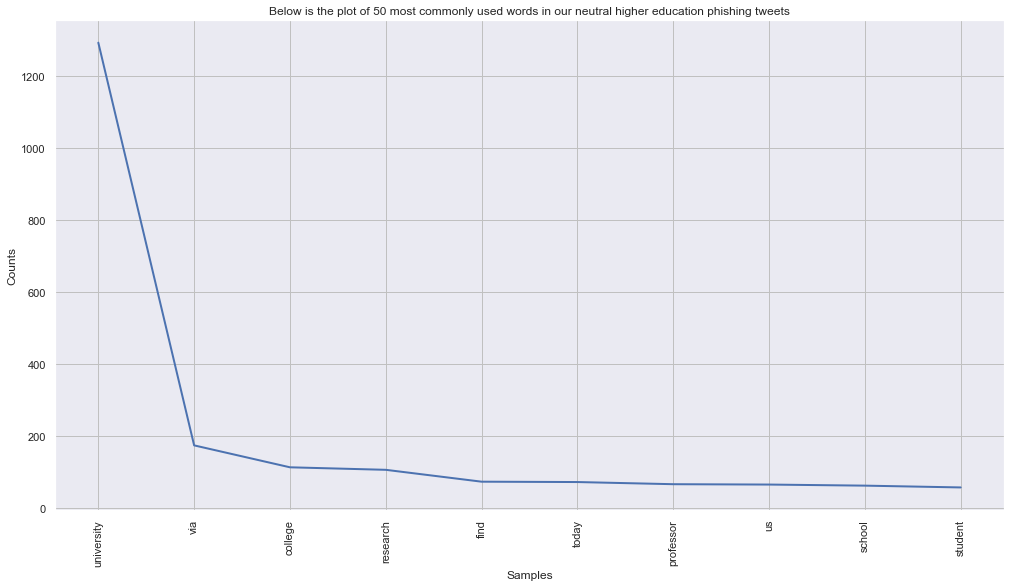

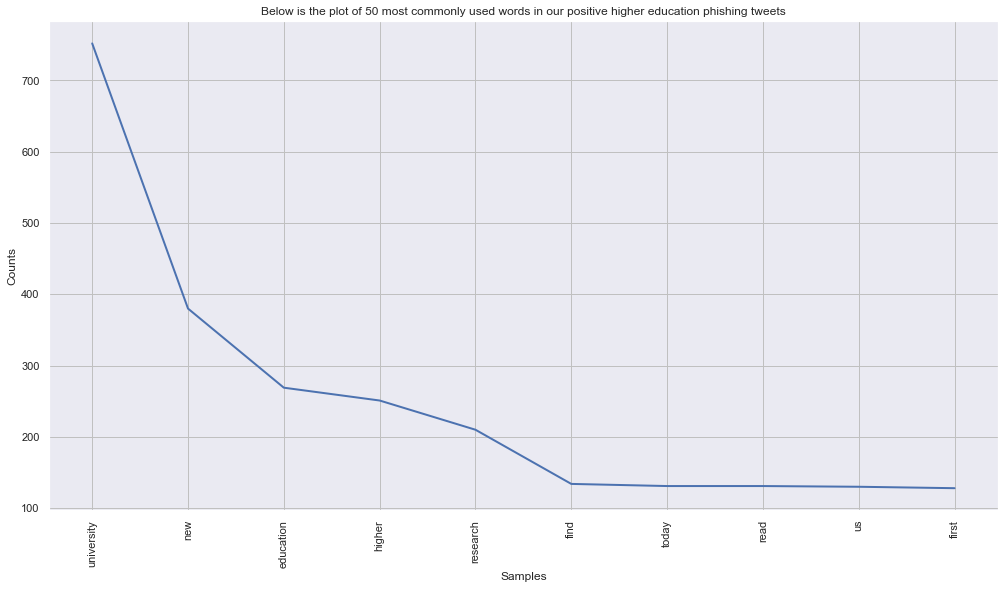

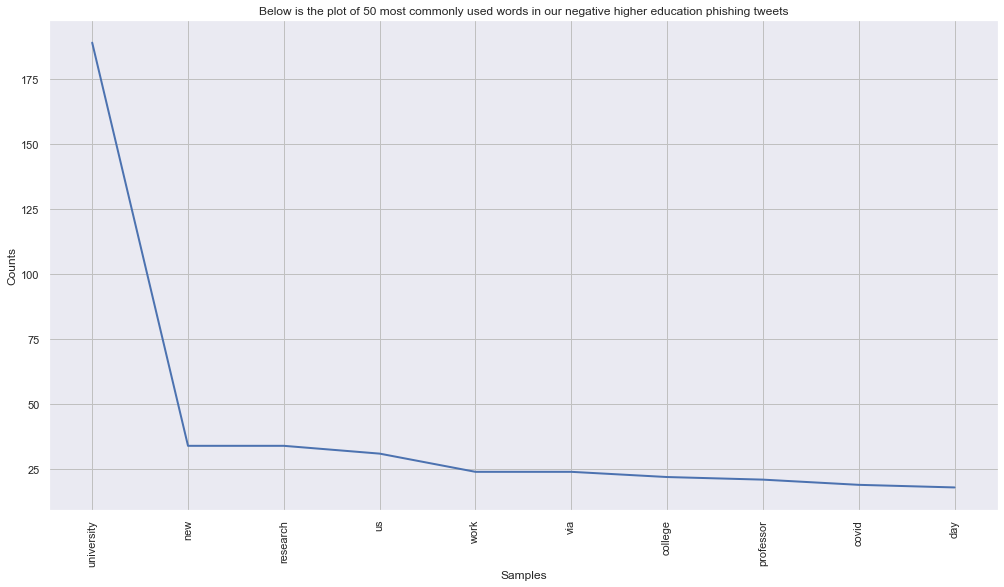

<AxesSubplot:title={'center':'Below is the plot of 50 most commonly used words in our negative higher education phishing tweets'}, xlabel='Samples', ylabel='Counts'>

In [31]:
# Determining most common words in sentiment tweets

# Lists to contain Phishing related words and URL's
neutral_text = []
neutral_link = []

neutral_df = dfCombined[dfCombined.Sentiment == 'Neutral']

for i in range(0,len(neutral_df)):
    neutral_text.append(neutral_df.Processed_Tweets.iloc[i])
    
# Graphing word and URL frequencies
# Spam text
neutral_text = ' '.join(neutral_text).split()
neutral_text_freq = nltk.FreqDist(neutral_text)

# Included for font
plt.rc('axes', unicode_minus=False)

# Phishing graph 1 (Text)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used words in our neutral higher education phishing tweets")
neutral_text_freq.most_common(10)
neutral_text_freq.plot(10)

# Lists to contain Phishing related words and URL's
Positive_text = []
Positive_link = []

Positive_df = dfCombined[dfCombined.Sentiment == 'Positive']

for i in range(0,len(Positive_df)):
    Positive_text.append(Positive_df.Processed_Tweets.iloc[i])
    
# Graphing word and URL frequencies
# Spam text
Positive_text = ' '.join(Positive_text).split()
Positive_text_freq = nltk.FreqDist(Positive_text)

# Included for font
plt.rc('axes', unicode_minus=False)

# Phishing graph 1 (Text)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used words in our positive higher education phishing tweets")
Positive_text_freq.most_common(10)
Positive_text_freq.plot(10)

# Lists to contain Phishing related words and URL's
Negative_text = []
Negative_link = []

Negative_df = dfCombined[dfCombined.Sentiment == 'Negative']

for i in range(0,len(Negative_df)):
    Negative_text.append(Negative_df.Processed_Tweets.iloc[i])
    
# Graphing word and URL frequencies
# Spam text
Negative_text = ' '.join(Negative_text).split()
Negative_text_freq = nltk.FreqDist(Negative_text)

# Included for font
plt.rc('axes', unicode_minus=False)

# Phishing graph 1 (Text)
plt.figure(figsize=(17,9))
plt.title("Below is the plot of 50 most commonly used words in our negative higher education phishing tweets")
Negative_text_freq.most_common(10)
Negative_text_freq.plot(10)

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


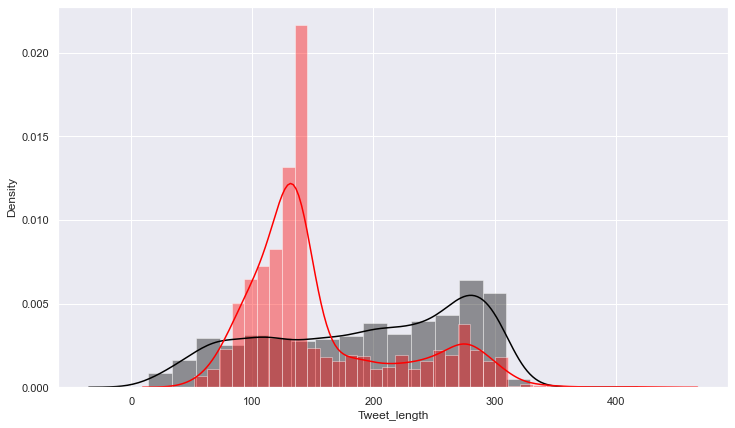

In [32]:
# Length
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].Tweet_length,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].Tweet_length,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


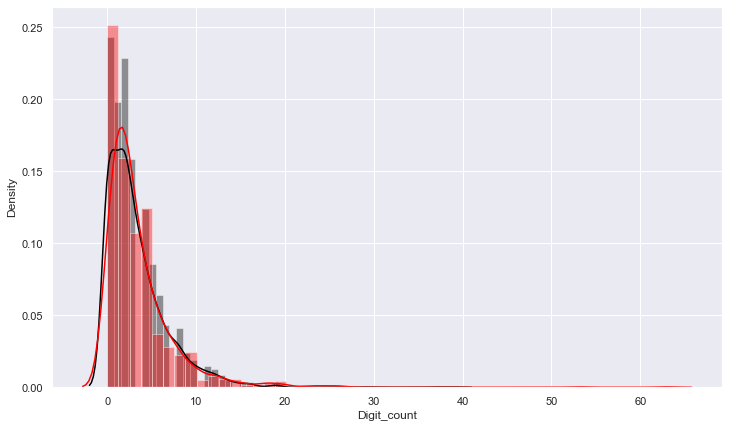

In [33]:
# Digits
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].Digit_count,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].Digit_count,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


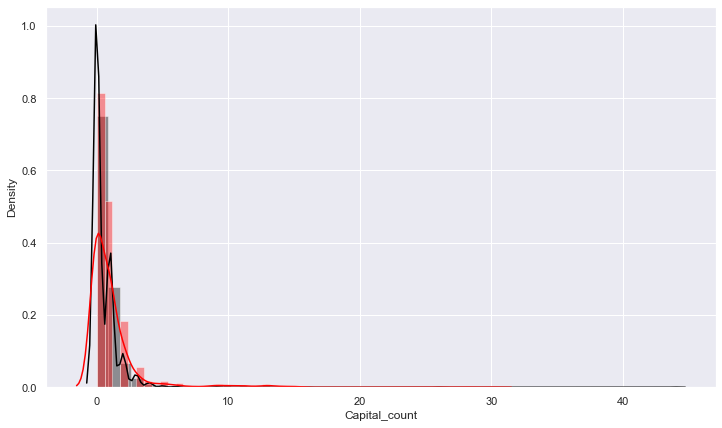

In [34]:
# Capitals
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].Capital_count,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].Capital_count,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


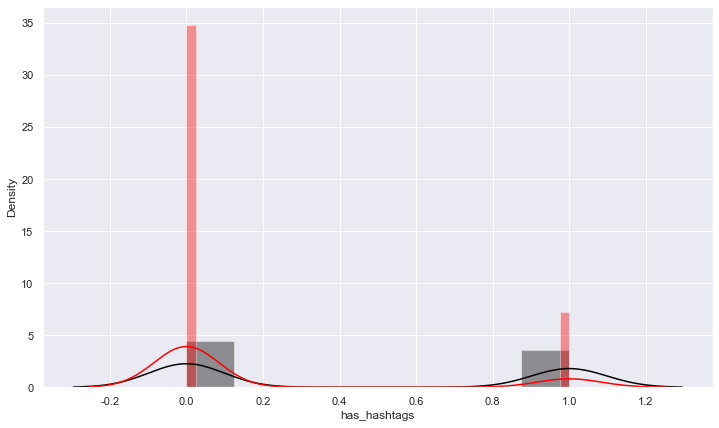

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


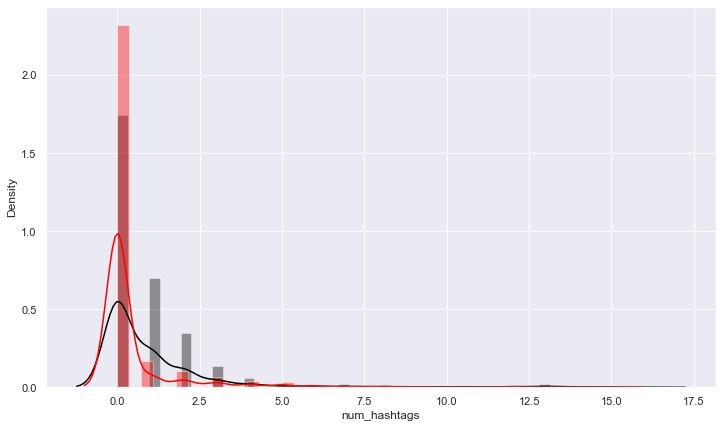

In [35]:
# Hashtags
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].has_hashtags,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].has_hashtags,color="red",kde=True)
plt.show()

plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].num_hashtags,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].num_hashtags,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


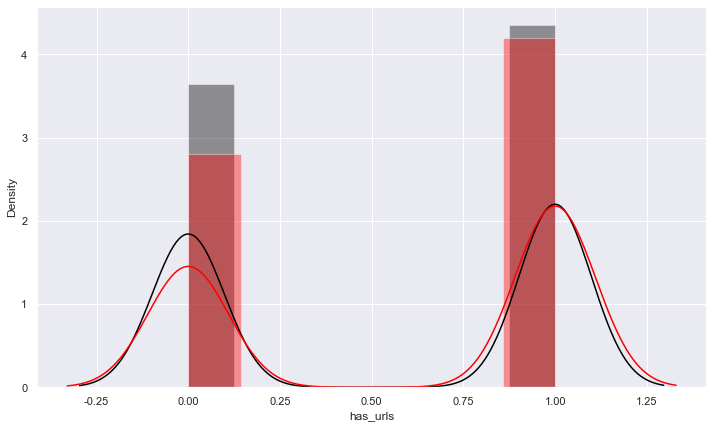

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


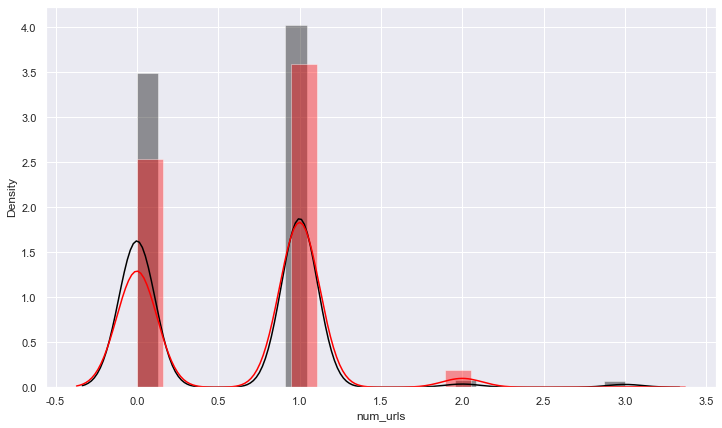

In [36]:
# URL
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].has_urls,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].has_urls,color="red",kde=True)
plt.show()

plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].num_urls,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].num_urls,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


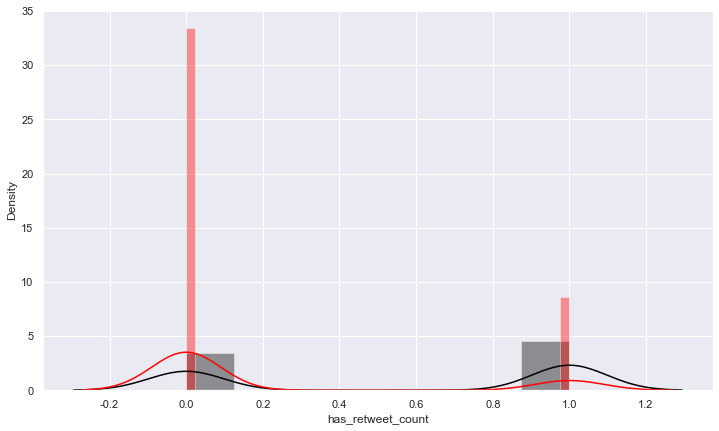

In [37]:
# Retweet
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].has_retweet_count,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].has_retweet_count,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


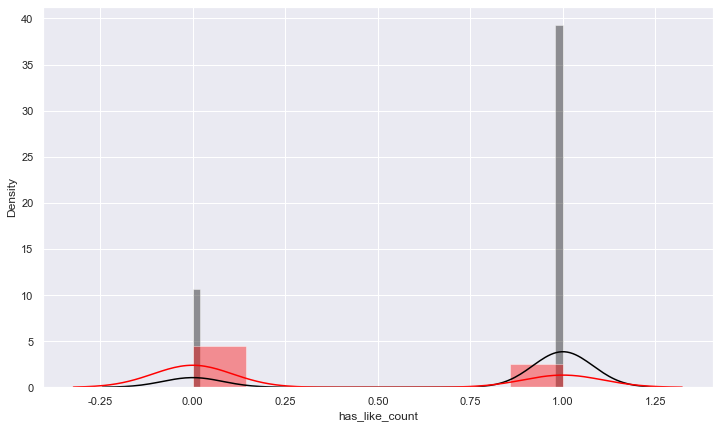

In [38]:
# Like
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].has_like_count,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].has_like_count,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


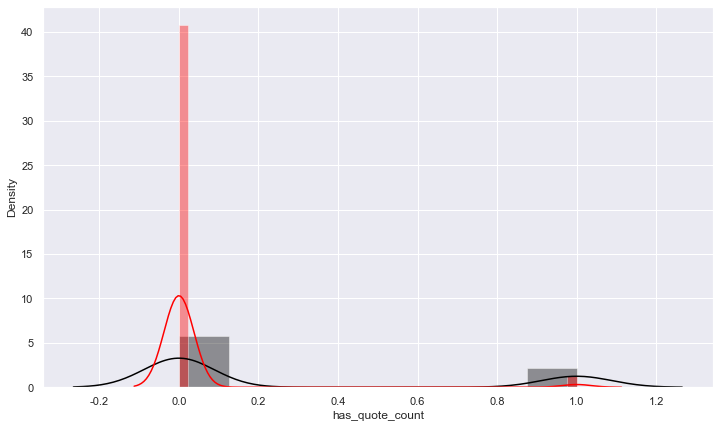

In [39]:
# Quote
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].has_quote_count,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].has_quote_count,color="red",kde=True)
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


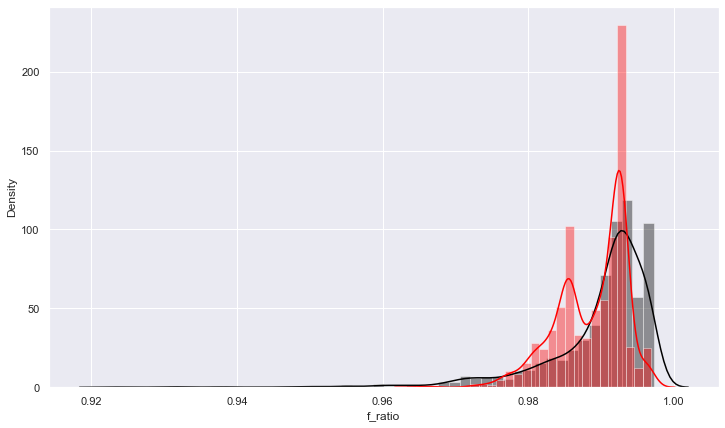

In [40]:
# F-ratio
plt.figure(figsize=(12,7))
sns.distplot(dfCombined[dfCombined.Status==0].f_ratio,color="black",kde=True)
sns.distplot(dfCombined[dfCombined.Status==1].f_ratio,color="red",kde=True)
plt.show()

# Sentiment significance

In [41]:
from scipy import stats
np.set_printoptions(suppress=True)

print("t tests for continuous variables")

list_continous_variables=['f_ratio','Tweet_length', 'Digit_count', 'Capital_count', 'has_hashtags', 'num_hashtags', 'has_urls', 'num_urls']

for i in list_continous_variables:
    print("\nVariable name:",i)
    test = stats.ttest_ind(dfCombined[i],dfCombined['Status'], equal_var = False)
    #print(test)
    if test.pvalue<0.05:
        print("The variable",i,"is significant, with a t-stat of",test.statistic)
    else:
        print("The variable",i,"is not significant")

t tests for continuous variables

Variable name: f_ratio
The variable f_ratio is significant, with a t-stat of 95.12529863011451

Variable name: Tweet_length
The variable Tweet_length is significant, with a t-stat of 163.26437845380386

Variable name: Digit_count
The variable Digit_count is significant, with a t-stat of 58.606900681191455

Variable name: Capital_count
The variable Capital_count is significant, with a t-stat of 15.195027868700913

Variable name: has_hashtags
The variable has_hashtags is not significant

Variable name: num_hashtags
The variable num_hashtags is significant, with a t-stat of 18.456874026265304

Variable name: has_urls
The variable has_urls is significant, with a t-stat of 22.042838071692625

Variable name: num_urls
The variable num_urls is significant, with a t-stat of 23.504702867302797


# Machine learning classifier: Naive Bayes Classifier (Text and URL)

In [120]:
# Seperating and concating Text and URL's into one column for learning 
NB_df = dfCombined[['Processed_Tweets', 'Outlinks', 'has_urls', 'num_urls', 'Status']]

def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')

NB_df['URL1'] = listToStringWithoutBrackets(dfCombined['Outlinks'])

NB_df['Combined'] = NB_df['Processed_Tweets'] + NB_df['URL1']

# Sample distribution
NB_df = NB_df.sample(frac=1)

# Instantiating Counter vectorizer and X data ('Combined' text and URL colum)
vecfinal = CountVectorizer(min_df=40,max_df=0.5,stop_words="english")
finalX = vecfinal.fit_transform(NB_df['Combined'])

# Specifying X and Y training and testing variables
X_train = finalX.toarray()[:4000]
X_test = finalX.toarray()[4000:len(finalX.toarray())]
y_train = NB_df.Status[:4000]
y_test = NB_df.Status[4000:len(NB_df)]

# Perform NB classifier
clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)
ypred = clf_nb.predict(X_test)
accuracy = f1_score(y_test, ypred, average='weighted')

# Print accuracy score
print("Accuracy for this model: ", accuracy*100,"%")

C:\Users\Dell\AppData\Local\Temp/ipykernel_11988/2105906940.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NB_df['URL1'] = listToStringWithoutBrackets(dfCombined['Outlinks'])
C:\Users\Dell\AppData\Local\Temp/ipykernel_11988/2105906940.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NB_df['Combined'] = NB_df['Processed_Tweets'] + NB_df['URL1']


Accuracy for this model:  81.63440237544806 %


In [121]:
# Confusion matrix
mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]

# Calculate classifier results and recall percentage

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

Confusion Matrix:

 [[629  68]
 [119 225]] 

True Positive Rate 84.09 %
True Negative Rate 76.79 %
Positive Predictive Value 90.24 %
Negative Predictive Value 65.41 %
False Positive Rate 23.21 %
False Negative Rate 15.91 %
False Discovery Rate 9.76 %
Overall Accuracy 82.04 %


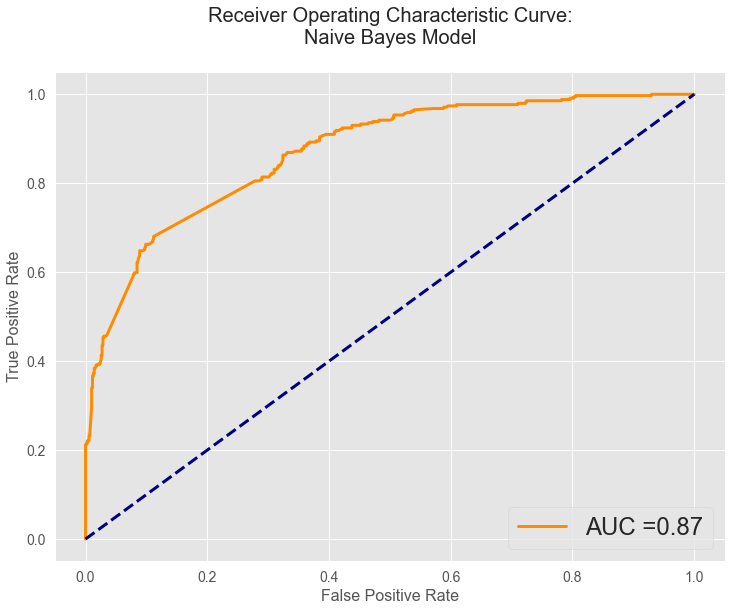

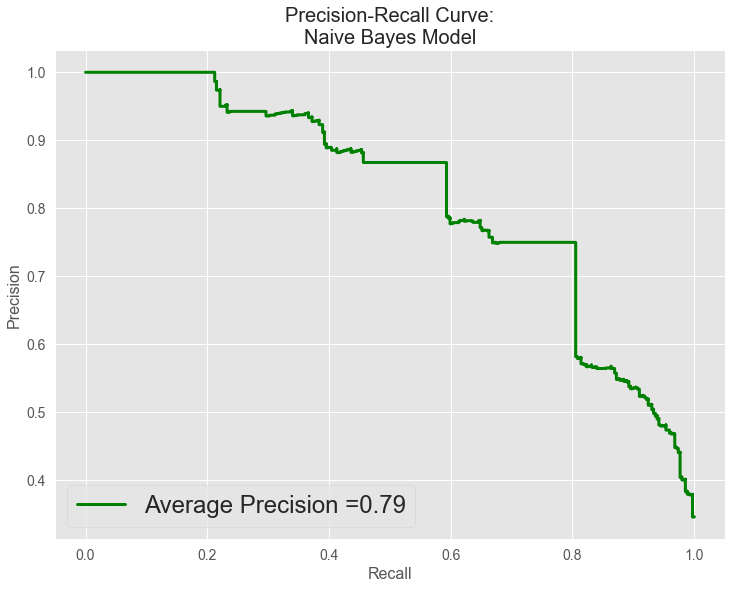

In [122]:
# Print and graph NB recall and accuracy

y_pred_proba_nb=clf_nb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nb)
average_precision = average_precision_score(y_test, y_pred_proba_nb)
naive_bayes_model_object1={}

# Graphing characteristic curve

# font size
large = 24

# Characteristic curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
plt.figure(figsize=(12,9))
y_pred_proba_knn = clf_nb.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

# NB object and predictive values
naive_bayes_model_object1={}
naive_bayes_model_object1['fpr']=fpr
naive_bayes_model_object1['tpr']=tpr
naive_bayes_model_object1['auc']=auc

# plot graph
plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nNaive Bayes Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

# Recall curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

# NB object and recall values
plt.figure(figsize=(12,9))
naive_bayes_model_object1['recall']=recall
naive_bayes_model_object1['precision']=precision
naive_bayes_model_object1['average_precision']=average_precision

# plot graph
plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nNaive Bayes Model')
plt.legend(loc="lower left")
plt.grid("off")

# show graphs
plt.show()

# Machine learning classifier: Naive Bayes Classifier (URL only)

In [123]:
# Seperating and concating Text and URL's into one column for learning 
NB_df = dfCombined[['Processed_URL', 'Outlinks', 'has_urls', 'num_urls', 'Status']]

def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')

NB_df['URL1'] = listToStringWithoutBrackets(dfCombined['Outlinks'])

NB_df['Combined'] = NB_df['Processed_URL'] + NB_df['URL1'] + str(NB_df['has_urls']) + str(NB_df['num_urls'])

# Sample distribution
NB_df = NB_df.sample(frac=1)

# Instantiating Counter vectorizer and X data ('Combined' text and URL colum)
vecfinal = CountVectorizer(min_df=1,max_df=0.5,stop_words="english")
finalX = vecfinal.fit_transform(NB_df['Combined'])

# Specifying X and Y training and testing variables
X_train = finalX.toarray()[:4000]
X_test = finalX.toarray()[4000:len(finalX.toarray())]
y_train = NB_df.Status[:4000]
y_test = NB_df.Status[4000:len(NB_df)]

# Perform NB classifier
clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)
ypred = clf_nb.predict(X_test)
accuracy = f1_score(y_test, ypred, average='weighted')

# Print accuracy score
print("Accuracy for this model: ", accuracy*100,"%")

C:\Users\Dell\AppData\Local\Temp/ipykernel_11988/946055055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NB_df['URL1'] = listToStringWithoutBrackets(dfCombined['Outlinks'])
C:\Users\Dell\AppData\Local\Temp/ipykernel_11988/946055055.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NB_df['Combined'] = NB_df['Processed_URL'] + NB_df['URL1'] + str(NB_df['has_urls']) + str(NB_df['num_urls'])


Accuracy for this model:  50.3847445771473 %


In [124]:
# Confusion matrix
mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]

# Calculate classifier results and recall percentage

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

Confusion Matrix:

 [[668   0]
 [372   1]] 

True Positive Rate 64.23 %
True Negative Rate 100.0 %
Positive Predictive Value 100.0 %
Negative Predictive Value 0.27 %
False Positive Rate 0.0 %
False Negative Rate 35.77 %
False Discovery Rate 0.0 %
Overall Accuracy 64.27 %


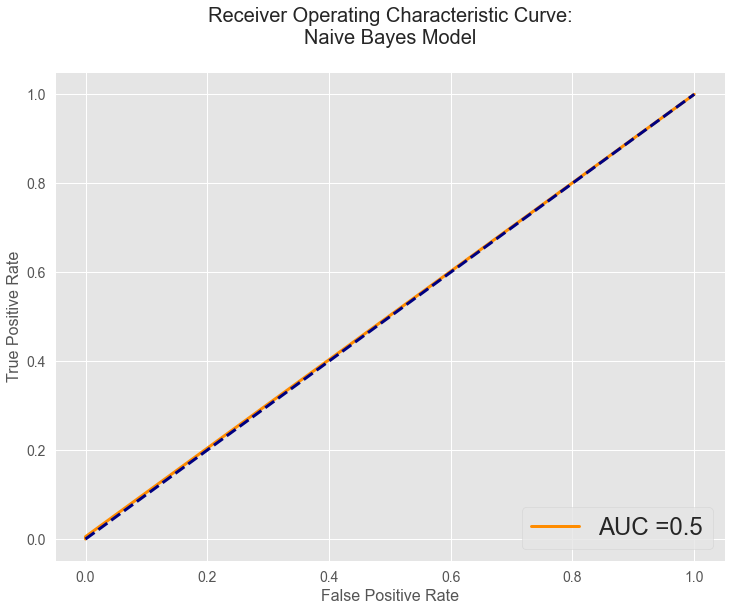

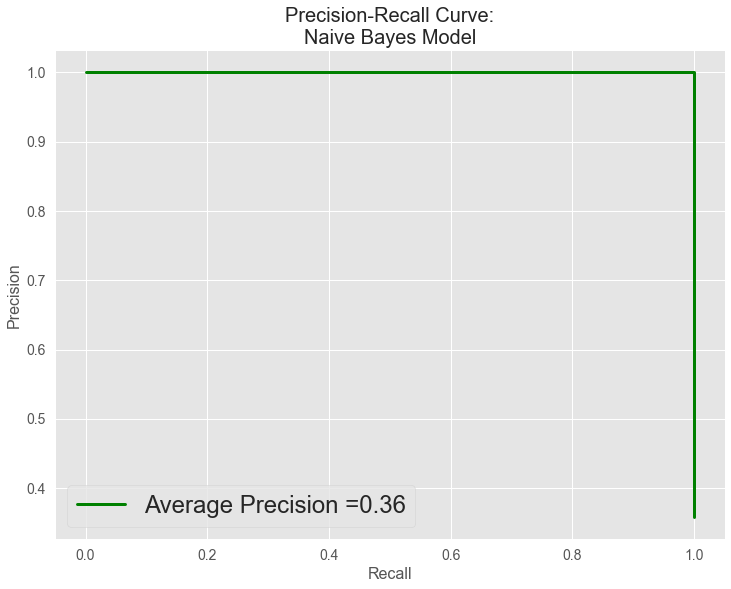

In [125]:
# Print and graph NB recall and accuracy

y_pred_proba_nb=clf_nb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nb)
average_precision = average_precision_score(y_test, y_pred_proba_nb)
naive_bayes_model_object={}

# Graphing characteristic curve

# font size
large = 24

# Characteristic curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
plt.figure(figsize=(12,9))
y_pred_proba_knn = clf_nb.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

# NB object and predictive values
naive_bayes_model_object={}
naive_bayes_model_object['fpr']=fpr
naive_bayes_model_object['tpr']=tpr
naive_bayes_model_object['auc']=auc

# plot graph
plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nNaive Bayes Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

# Recall curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

# NB object and recall values
plt.figure(figsize=(12,9))
naive_bayes_model_object['recall']=recall
naive_bayes_model_object['precision']=precision
naive_bayes_model_object['average_precision']=average_precision

# plot graph
plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nNaive Bayes Model')
plt.legend(loc="lower left")
plt.grid("off")

# show graphs
plt.show()

# Machine learning classifier: Decision Tree Classifier

In [126]:
# Determining our X and Y values for deicision tree learning
y = dfCombined.Status # X is status
X = dfCombined[['has_hashtags', 'num_hashtags', 'has_urls', 'has_quote_count', 'has_like_count', 'has_retweet_count', 'Tweet_length', 'Digit_count', 'Capital_count']] # Y is associated columns that can be used to determine spear phishing
model = X

# Spltting train and test splits
X_train, X_test, y_train, y_test = train_test_split(model, y, test_size = 0.5) # Train and test split remains 0.5

# Lists to hold calculated depth and scores
depth = []
training_score = []
testing_score = []

# Print DC model accuracy scores
print("Decision Tree Model: Training and Testing accuracy scores for each depth\n")

# For exach depth make prediction and print values
for i in range(1,25):
    clf = DecisionTreeClassifier(criterion = "gini")
    clf.max_depth = i
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    print("Training accuracy, with",i,"depth :",accuracy_score(pred_train,y_train)*100)
    
    clf.fit(X_train, y_train)
    pred_test = clf.predict(X_test)
    print("Testing accuracy, with",i,"depth :",accuracy_score(pred_test,y_test)*100,"\n")
    
    depth.append(i)
    training_score.append(accuracy_score(pred_train,y_train))
    testing_score.append(accuracy_score(pred_test,y_test))

Decision Tree Model: Training and Testing accuracy scores for each depth

Training accuracy, with 1 depth : 73.61111111111111
Testing accuracy, with 1 depth : 73.6215787385958 

Training accuracy, with 2 depth : 76.86507936507937
Testing accuracy, with 2 depth : 74.81158270527568 

Training accuracy, with 3 depth : 79.36507936507937
Testing accuracy, with 3 depth : 76.59658865529552 

Training accuracy, with 4 depth : 80.03968253968254
Testing accuracy, with 4 depth : 76.67592225307418 

Training accuracy, with 5 depth : 82.34126984126983
Testing accuracy, with 5 depth : 78.02459341531139 

Training accuracy, with 6 depth : 84.16666666666667
Testing accuracy, with 6 depth : 78.26259420864736 

Training accuracy, with 7 depth : 86.26984126984128
Testing accuracy, with 7 depth : 80.12693375644585 

Training accuracy, with 8 depth : 87.73809523809524
Testing accuracy, with 8 depth : 78.81792939309797 

Training accuracy, with 9 depth : 89.52380952380953
Testing accuracy, with 9 depth : 78

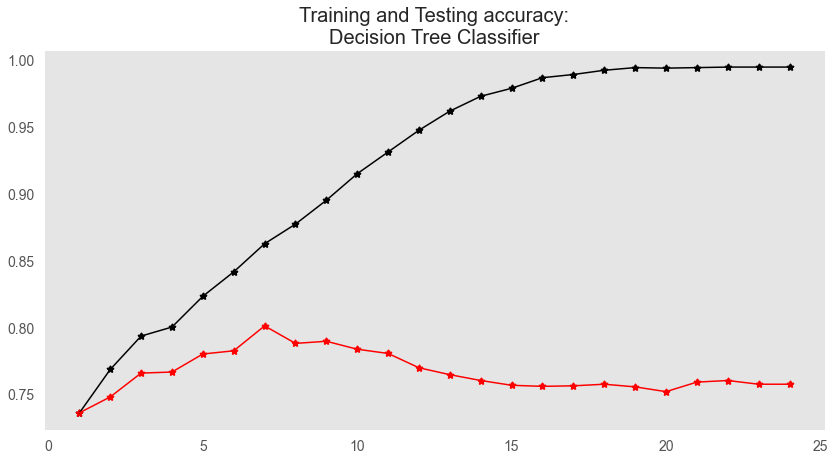

In [127]:
# Plotting training and testing accuracy scores

# plot graph
plt.figure(figsize=(14,7))
plt.title('Training and Testing accuracy:\nDecision Tree Classifier')
plt.grid()
plt.plot(depth, training_score,c='black')
plt.plot(depth, testing_score,c='red')
plt.scatter(depth, training_score,c='black',marker='*',linewidth=2)
plt.scatter(depth, testing_score,c='red',marker='*',linewidth=2)

In [128]:
# Determining the best search parameters for DC model

# X model and values
X = model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5) # Train and test split remains 0.5
    
clf = DecisionTreeClassifier()

# Parameter grid
param_grid = {
              "criterion": ["gini", "entropy"],
              "max_depth": list(np.arange(1,50,1)),
              }
 
CLF = GridSearchCV(estimator = clf, param_grid=param_grid, cv = 5)
CLF.fit(X_train, y_train)
CLF.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [129]:
# Print and graph DC recall and accuracy
clf = DecisionTreeClassifier(criterion='entropy',max_depth=7)
clf.fit(X_train,y_train)
ypred = clf.predict(X_test)
print("Accuracy for this model:",accuracy_score(ypred,y_test)*100,"%")

Accuracy for this model: 81.47560491868306 %


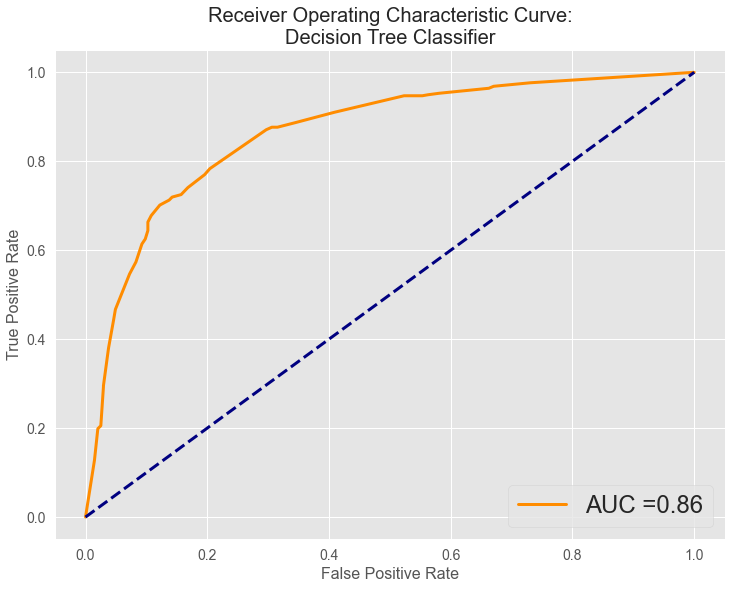

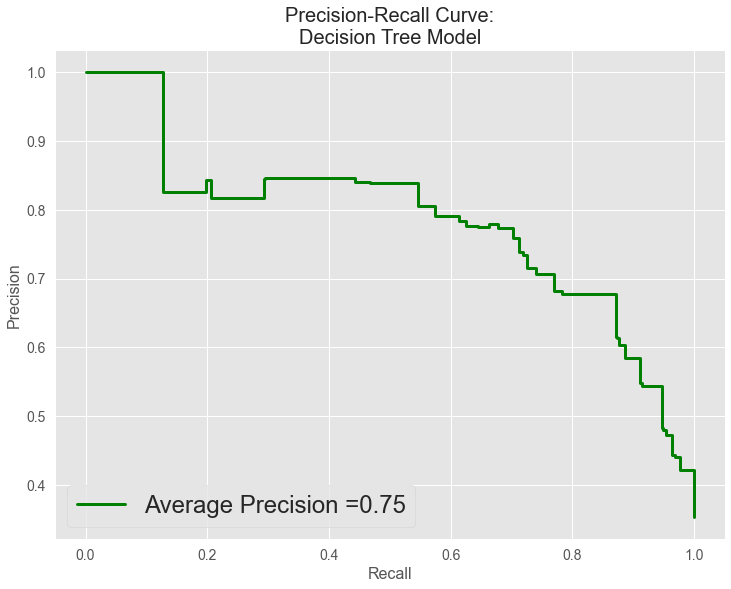

In [130]:
# Print and graph DC recall and accuracy

# Graphing characteristic curve

# font size
large = 24

# Characteristic curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
plt.figure(figsize=(12,9))
y_pred_proba_knn =clf.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

# DC object and predictive values
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)
dt_model_object={}
dt_model_object['fpr']=fpr
dt_model_object['tpr']=tpr
dt_model_object['auc']=auc

# plot graph
plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nDecision Tree Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

# Recall curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
plt.figure(figsize=(12,9))

# DC object and recall values
y_pred_proba_dt =clf.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_dt)
average_precision = average_precision_score(y_test, y_pred_proba_dt)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
dt_model_object['recall']=recall
dt_model_object['precision']=precision
dt_model_object['average_precision']=average_precision

# plot graph
plt.title('Precision-Recall Curve:\nDecision Tree Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid("off")

# show graphs
plt.show()

# Machine learning classifier: KNN Classifier

In [131]:
# Determining our X and Y values for deicision tree learning
X = model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

# Instantiate the nighbour classifier
neigh = KNeighborsClassifier()

# Parameter grid
k = np.arange(20)+1
param_grid = {'n_neighbors': k}
                                 
# For each grid search, perfrom training and make predictions
CLF = GridSearchCV(estimator = neigh, param_grid = param_grid, cv = 5)
CLF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])})

In [132]:
# identify the best parameters
CLF.best_params_

{'n_neighbors': 11}

In [133]:
# Print and graph DC recall and accuracy
neigh = KNeighborsClassifier(n_neighbors = 6)
neigh.fit(X_train,y_train)
ypred = CLF.predict(X_test)
print("Accuracy for this model:",accuracy_score(ypred,y_test)*100,"%")

Accuracy for this model: 76.27925426418088 %


In [134]:
# Confusion matrix
mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1433  204]
 [ 394  490]] 



In [135]:
# Calculate classifier results and recall percentage

TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]
print(TP,FP,FN,TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

1433 204 394 490
True Positive Rate 78.43 %
True Negative Rate 70.61 %
Positive Predictive Value 87.54 %
Negative Predictive Value 55.43 %
False Positive Rate 29.39 %
False Negative Rate 21.57 %
False Discovery Rate 12.46 %
Overall Accuracy 76.28 %


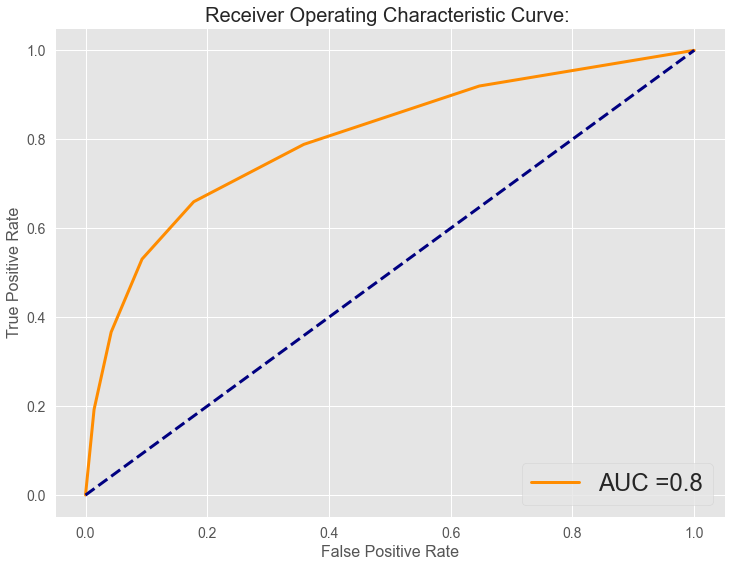

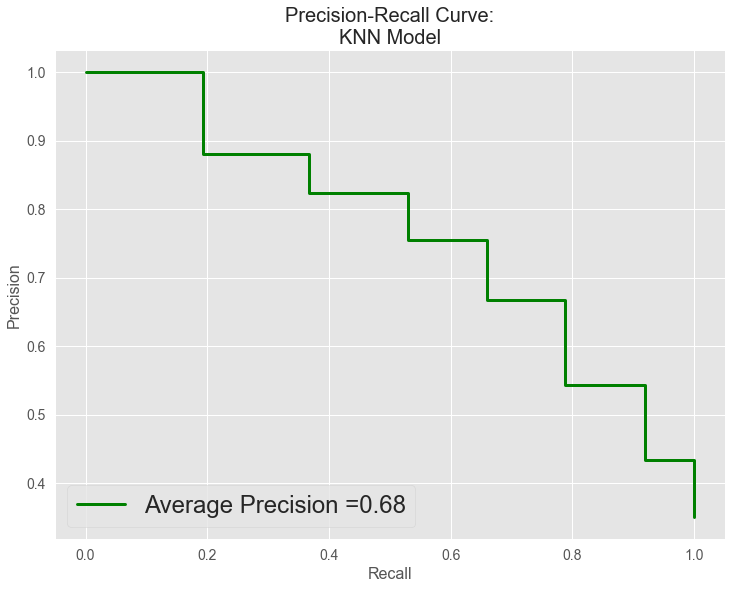

In [136]:
# Print and graph KNN recall and accuracy

# Graphing characteristic curve

# font size
large = 24

# Characteristic curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn = neigh.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

# KNN object and predictive values
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)
knn_model_object={}
knn_model_object['fpr']=fpr
knn_model_object['tpr']=tpr
knn_model_object['auc']=auc

# plot graph
plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: ')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

# Recall curve
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
plt.figure(figsize=(12,9))

# KNN object and recall values
y_pred_proba_knn = neigh.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_knn)
average_precision = average_precision_score(y_test, y_pred_proba_knn)

# plot graph
plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
knn_model_object['recall']=recall
knn_model_object['precision']=precision
knn_model_object['average_precision']=average_precision
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nKNN Model')
plt.legend(loc="lower left")
plt.grid("off")

# Show graphs
plt.show()

# Machine learning classifier: Random Forest Classifier

In [137]:
rfc = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

rfc.fit(X_train,y_train)
ypred = rfc.predict(X_test)
print("Prediction Accuracy:",accuracy_score(ypred,y_test)*100,"%")

Prediction Accuracy: 80.32526775089251 %


In [138]:
mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1402  202]
 [ 294  623]] 



In [139]:
TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")


# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

True Positive Rate 82.67 %
True Negative Rate 75.52 %
Positive Predictive Value 87.41 %
Negative Predictive Value 67.94 %
False Positive Rate 24.48 %
False Negative Rate 17.33 %
False Discovery Rate 12.59 %
Overall Accuracy 80.33 %


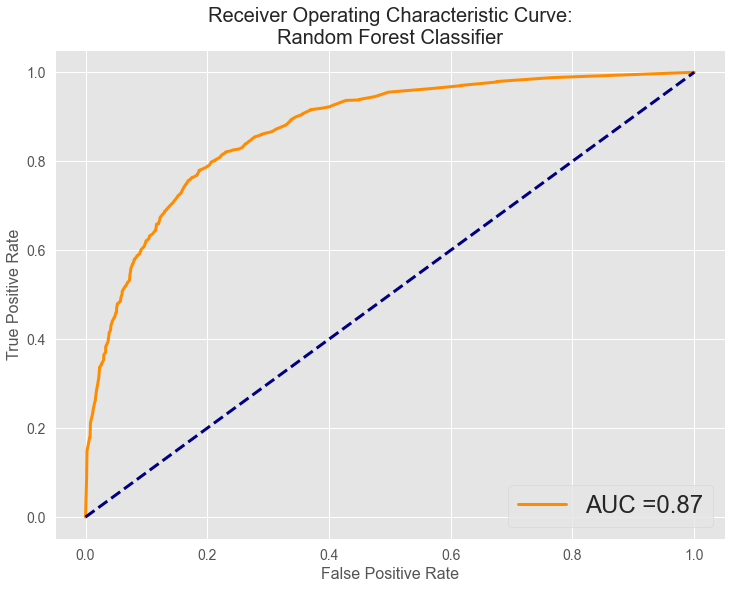

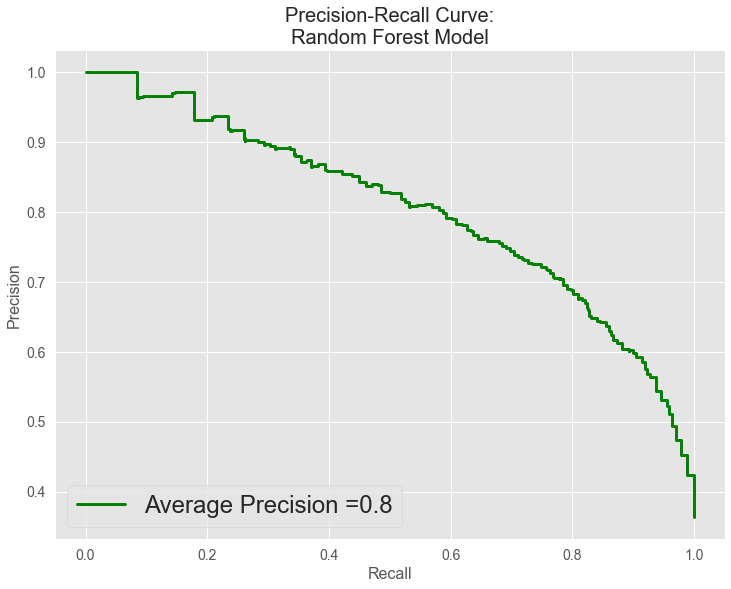

In [140]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rfc)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rfc)

rfc_model_object={}
rfc_model_object['fpr']=fpr
rfc_model_object['tpr']=tpr
rfc_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nRandom Forest Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rfc)
average_precision = average_precision_score(y_test, y_pred_proba_rfc)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
rfc_model_object['recall']=recall
rfc_model_object['precision']=precision
rfc_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nRandom Forest Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

# Machine learning classifier: Support Vector Machine (SVM) Classifier

In [141]:
# instantiate classifier with default hyperparameters
svc=SVC() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print("Prediction Accuracy with default hyperparameters:",accuracy_score(y_test, y_pred)*100,"%")

Prediction Accuracy with default hyperparameters: 71.87623958746529 %


In [142]:
mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1184  447]
 [ 262  628]] 



In [143]:
TP = mat[0][0]
FP = mat[0][1]
FN = mat[1][0]
TN = mat[1][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Positive Rate",round(TPR*100,2),"%")

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate",round(TNR*100,2),"%")

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value",round(PPV*100,2),"%")

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value",round(NPV*100,2),"%")

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate",round(FPR*100,2),"%")

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate",round(FNR*100,2),"%")

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate",round(FDR*100,2),"%")


# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy",round(ACC*100,2),"%")

True Positive Rate 81.88 %
True Negative Rate 58.42 %
Positive Predictive Value 72.59 %
Negative Predictive Value 70.56 %
False Positive Rate 41.58 %
False Negative Rate 18.12 %
False Discovery Rate 27.41 %
Overall Accuracy 71.88 %


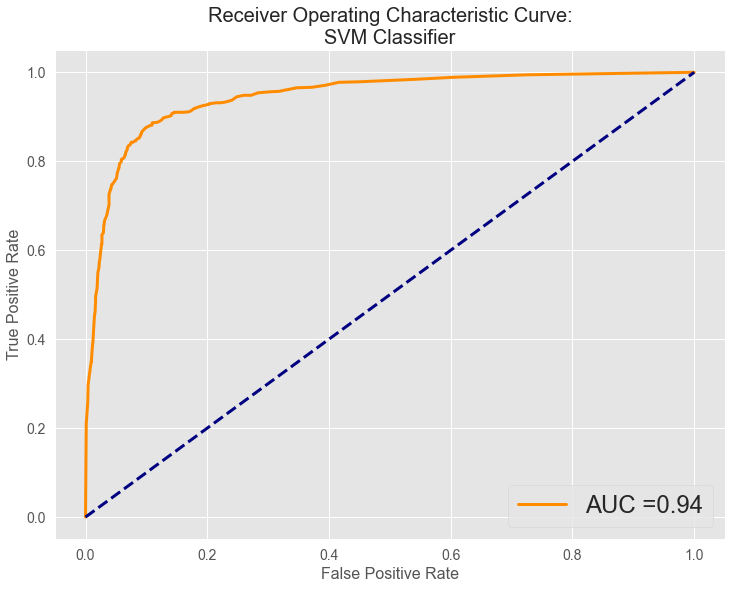

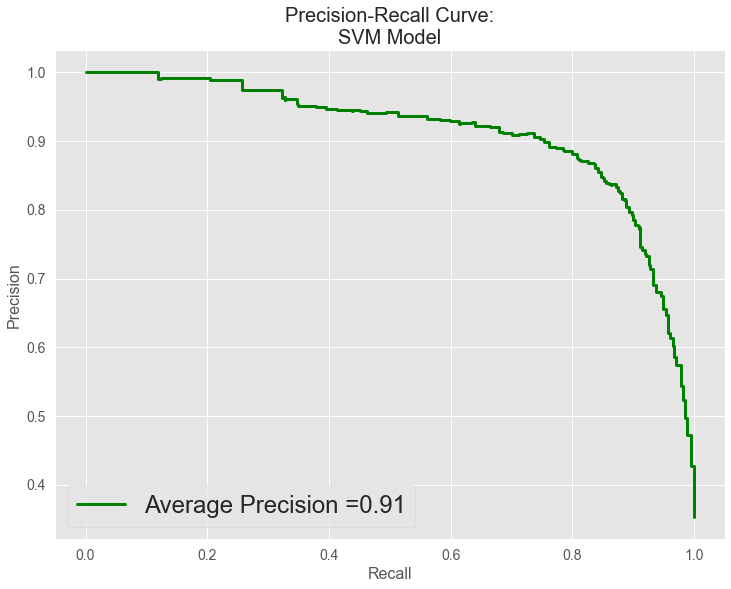

In [144]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rfc)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rfc)

svc_model_object={}
svc_model_object['fpr']=fpr
svc_model_object['tpr']=tpr
svc_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nSVM Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rfc)
average_precision = average_precision_score(y_test, y_pred_proba_rfc)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
svc_model_object['recall']=recall
svc_model_object['precision']=precision
svc_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nSVM Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

# Machine learning classifier: Neural Network

In [145]:
NN_df = dfCombined[['Processed_Tweets', 'Outlinks', 'has_urls', 'num_urls', 'Status']]

NN_df['URL1'] = listToStringWithoutBrackets(dfCombined['Outlinks'])
NN_df['URL2'] = NB_df['has_urls'].agg(lambda x: ','.join(map(str, x)))

for index, row in dfCombined.iterrows():
    sentences = NN_df['Processed_Tweets'] + NN_df['URL1'] + NN_df['URL2']
    y = NN_df['Status'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

C:\Users\Dell\AppData\Local\Temp/ipykernel_11988/2739463247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NN_df['URL1'] = listToStringWithoutBrackets(dfCombined['Outlinks'])
C:\Users\Dell\AppData\Local\Temp/ipykernel_11988/2739463247.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NN_df['URL2'] = NB_df['has_urls'].agg(lambda x: ','.join(map(str, x)))


In [146]:
from keras.models import Sequential
from keras import layers


input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [147]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60260     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 60,271
Trainable params: 60,271
Non-trainable params: 0
_________________________________________________________________


In [148]:
history = model.fit(X_train, y_train,epochs=100,verbose=False,validation_data=(X_test, y_test),batch_size=10)

C:\Users\Dell\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [149]:
from keras.backend import clear_session
clear_session()

In [150]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9905
Testing Accuracy:  0.8303


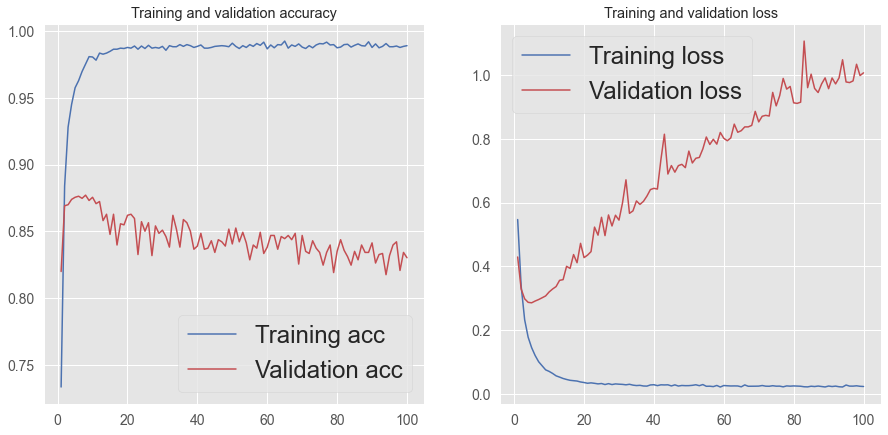

In [151]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Machine learning classifier: K-means Classifier

In [ ]:
kmeans = KMeans(n_clusters=2)

y = kmeans.fit_predict(df[['has_hashtags', 'num_hashtags', 'has_urls', 'num_urls', 'has_quote_count', 'has_like_count', 'has_retweet_count', 'Tweet_length', 'Digit_count', 'Capital_count']])

df['Cluster'] = y

print(df.head())


In [ ]:
kmeans = KMeans(n_clusters=40).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

In [ ]:
plt.xlabel('Cluster')
plt.ylabel('No of identifiers')
plt.title('Receiver Characteristic Classification Grid: K-means Classifier\n')
plt.scatter(df['has_urls'], df['Cluster'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# Comparitive evaluation of machine learning classifiers and their effectiveness

# Receiver operating characteristics

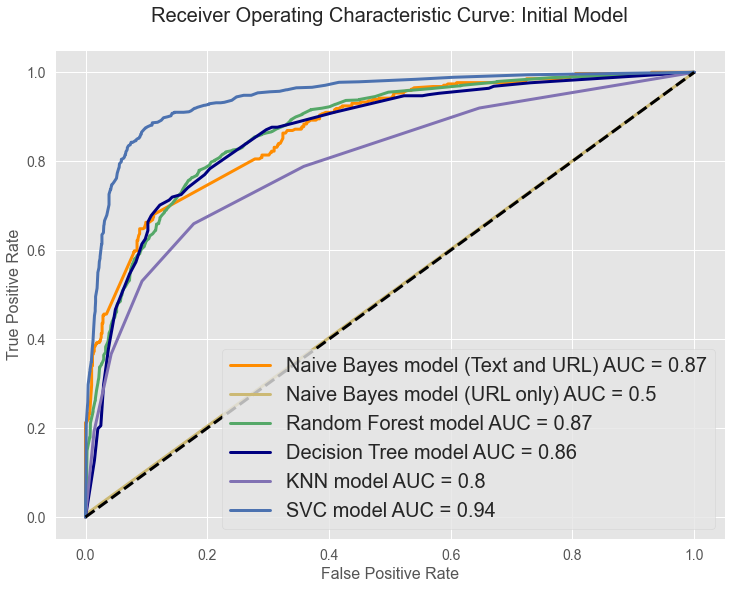

In [152]:
large = 20

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))


plt.plot(naive_bayes_model_object1['fpr'],naive_bayes_model_object1['tpr'],label="Naive Bayes model (Text and URL) AUC = "+str(round(naive_bayes_model_object1['auc'],2)), lw=3,color='darkorange')
plt.plot(naive_bayes_model_object['fpr'],naive_bayes_model_object['tpr'],label="Naive Bayes model (URL only) AUC = "+str(round(naive_bayes_model_object['auc'],2)), lw=3,color='y')
plt.plot(rfc_model_object['fpr'],rfc_model_object['tpr'],label="Random Forest model AUC = "+str(round(rfc_model_object['auc'],2)), lw=3,color='g')
plt.plot(dt_model_object['fpr'],dt_model_object['tpr'],label="Decision Tree model AUC = "+str(round(dt_model_object['auc'],2)), lw=3,color='navy')
plt.plot(knn_model_object['fpr'],knn_model_object['tpr'],label="KNN model AUC = "+str(round(knn_model_object['auc'],2)), lw=3,color='m')
plt.plot(svc_model_object['fpr'],svc_model_object['tpr'],label="SVC model AUC = "+str(round(svc_model_object['auc'],2)), lw=3,color='b')

plt.plot([0, 1], [0, 1], color='black', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: Initial Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

# Precision recall

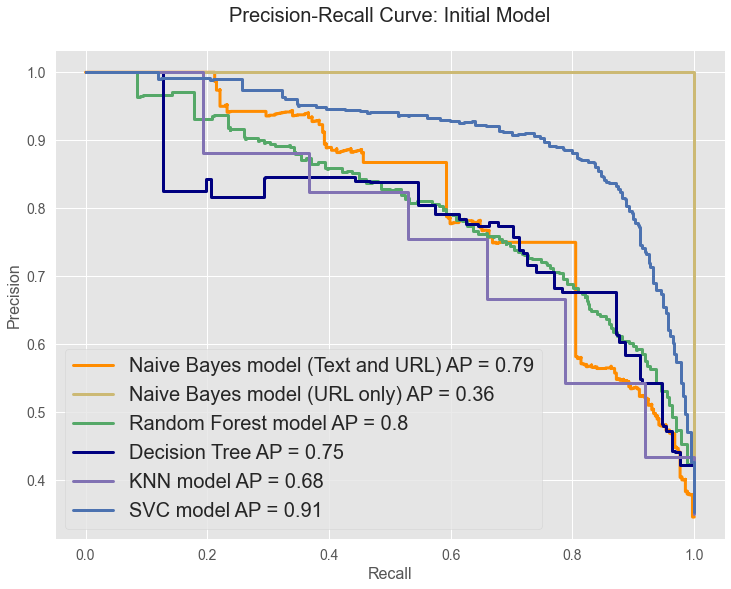

In [153]:
large = 20

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))



plt.step(naive_bayes_model_object1['recall'], naive_bayes_model_object1['precision'], color='darkorange',label="Naive Bayes model (Text and URL) AP = "+str(round(naive_bayes_model_object1['average_precision'],2)),lw=3)
plt.step(naive_bayes_model_object['recall'], naive_bayes_model_object['precision'], color='y',label="Naive Bayes model (URL only) AP = "+str(round(naive_bayes_model_object['average_precision'],2)),lw=3)
plt.step(rfc_model_object['recall'], rfc_model_object['precision'], color='g',label="Random Forest model AP = "+str(round(rfc_model_object['average_precision'],2)),lw=3)
plt.step(dt_model_object['recall'], dt_model_object['precision'], color='navy',label="Decision Tree AP = "+str(round(dt_model_object['average_precision'],2)),lw=3)
plt.step(knn_model_object['recall'], knn_model_object['precision'], color='m',label="KNN model AP = "+str(round(knn_model_object['average_precision'],2)),lw=3)
plt.step(svc_model_object['recall'], svc_model_object['precision'], color='b',label="SVC model AP = "+str(round(svc_model_object['average_precision'],2)),lw=3)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Initial Model\n')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()